## OECD Healthcare Spending Analysis

**Group Member:** SeoYoung Ha

---

**TABLE OF CONTENTS**

1. Introduction to Dataset
2. Exploratory Data Analysis
3. Single-country Regressions
4. Causal Analysis with Fixed Effects
5. Using Predicative Models to Identify Predictors

    a. LASSO
    
    b. Random Forest

**Introduction and Data Description**

[The OECD Public Finance Dataset](https://www.oecd.org/economy/public-finance/oecd-public-finance-dataset.htm), which is a combination of other OECD datasets like the OECD Annual National Accounts Dataset, offers a detailed, annual view of public expenditure and revenues by country since 1960 (when applicable). Frozen for the fiscal items and other macroeconomic data on May 28, 2018, it was initially structured to analyze the impact of fiscal variables on growth and income inequality. It adheres to the National System of Accounts (SNA) methodology, as outlined in the dataset’s methodology document, acessible for futher reading [here](https://www.oecd.org/economy/public-finance/The_OECD_Public_Finance_Dataset_Sources_and_Methods.pdf). SNA is an international set of guidelines that outlines how to compile measures of economic activity by integrating various data types and expenditure breakdowns and revenue statistics, and along structural and institutional indicators (ex. Education, health, social security contributions, and environmental taxes). Preprocessing of the dataset performed by OECD involves cyclical adjustments to account for business cycle fluctuations, done by adjusting unemployment benefits and other income-related transfers (family and child benefits) using the [Price et al. (2015)](https://www.oecd-ilibrary.org/economics/adjusting-fiscal-balances-for-the-business-cycle_5jrp1g3282d7-en) methodology.

In addition to the primary dataset, we made the decision to include a supplementary dataset in project, particularly to better capture health outcomes quantitatively by country. It follows that we chose life expectancy at birth to be our non-financial metric for health outcomes, which we pulled from datasets of the same title (the [OECD Life Expectancy at Birth Dataset](https://data.oecd.org/healthstat/life-expectancy-at-birth.htm#indicator-chart)). This dataset provides vital metrics for assessing health outcomes in respective countries and are consistent with the OECD's data collection methodology from the OECD Public Finance Dataset, ensuring uniformity in terms of accuracy and reliability of our analysis. Note that the supplementary dataset has observations split by country, year, and sex at birth. For the purposes of this project, we chose to not consider sex at birth, instead opting to take the "total" observation versions from both datasets.

Our initial exploration of the data involves initial exploratory analysis, data cleaning, and analysis in the form of modeling to provide early insights and initial findings. These steps act as our own form of preprocessing in preparation for our project purpose, outlined later in the document. We first began our analysis by taking a snapshot of the variables that existed within the Public Finance Dataset, in an effort to initially address data missingness and reorganisation: 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LassoCV, RidgeCV
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from statsmodels.stats.outliers_influence import variance_inflation_factor
from IPython.display import FileLink
from scipy.cluster import hierarchy
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler

In [2]:
# Loading the Data
df = pd.read_csv('CS109acleandata.csv')

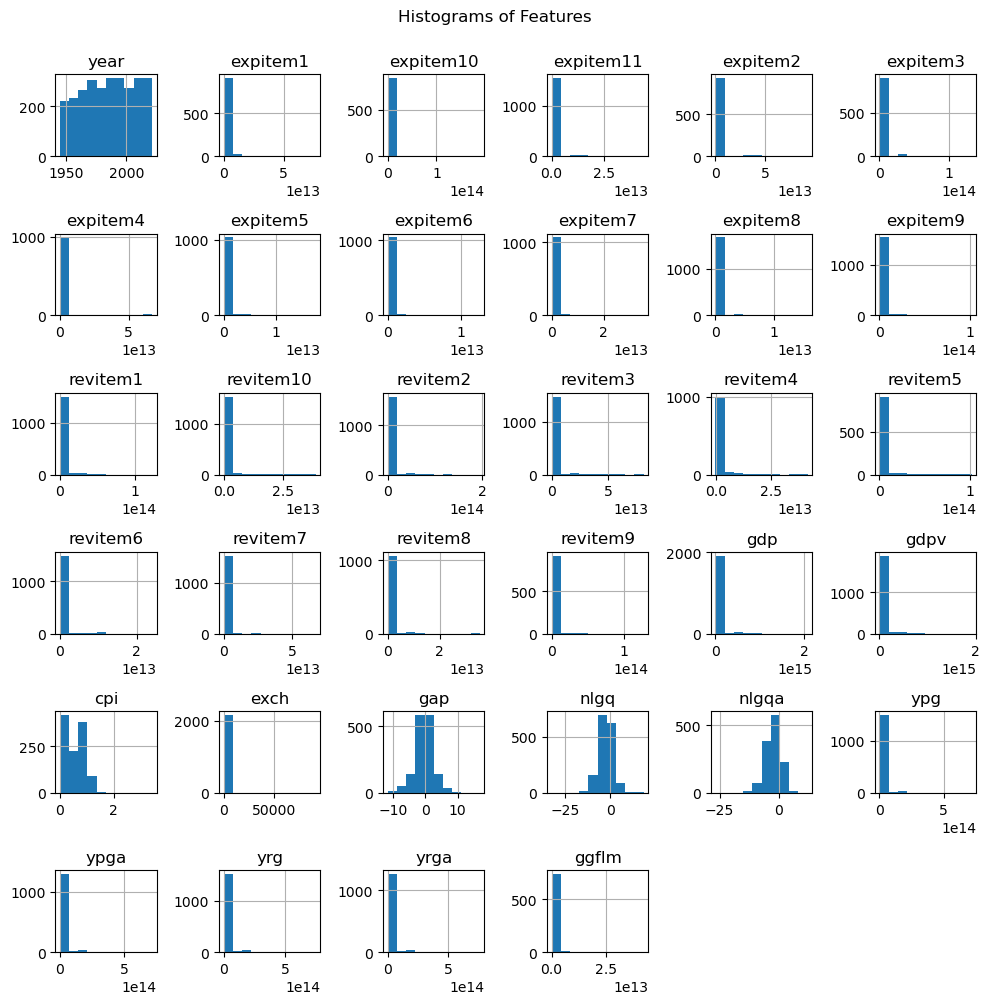

In [3]:
# What the Histograms look like before reorganizing data frame
# Histograms
df.hist(figsize=(10, 10))
plt.suptitle("Histograms of Features", y=1)
plt.tight_layout()
plt.show()

**Handling Data Missingness and Reorganizing Data Frame**

The histogram visualizations from the exploratory data analysis (EDA) on the Public Finance dataset pictured above show wide variance in the distribution of variables. Many features exhibit a concentration of values at lower ranges with sparse data spread across the higher ranges, suggesting a long-tail distribution. This concenrtation in values could imply that for many variables, a majority of observations have very low or null values, with only few countries having record of the variable being recorded. This pattern is especially true of countries that may not have existed at the beginning of the dataset (1960) or not having salvagable data for the time. 

We can further understand this missingness by looking at the percentage of missing values for each variable:

In [4]:
missing_percentage = (df.isnull().sum() / len(df)) * 100

# Display the percentage of missing values for each column
print("\nMissing Percentage:")
print(missing_percentage)


Missing Percentage:
iso3          0.000000
year          0.000000
expitem1     65.956692
expitem10    69.222577
expitem11    42.137025
expitem2     65.779198
expitem3     66.631168
expitem4     62.974796
expitem5     61.164359
expitem6     61.341853
expitem7     60.915868
expitem8     37.983671
expitem9     42.208023
revitem1     44.053958
revitem10    42.137025
revitem2     41.143060
revitem3     44.053958
revitem4     62.158324
revitem5     65.140220
revitem6     44.053958
revitem7     44.053958
revitem8     60.028399
revitem9     66.382677
gdp          28.541001
gdpv         28.611999
cpi          60.276890
exch         23.003195
gap          44.266951
nlgq         43.237487
nlgqa        54.242102
ypg          43.556976
ypga         51.828186
yrg          42.669507
yrga         52.822151
ggflm        72.878949
dtype: float64


We see that our hypothesis is true, where a majority of our variables have null values. Our group's intuition for a course of action involves cutting the year span from 1960 - 2021, a time when countires when OECD countries like Israel (ISR) did not yet exist, to 1995-2021, as 1950-1995 contains the majority of null variables we observe by eye. Additionally, we will cut countries that do not have enough data to justify further imputation and lack data for variable "expitem2", the Health expenditure variable. In context, we could broadly attribute missingness in expitem2 to have to do with reporting differences between nations, who many not discluse sufficent financial information to fall unled the guidelines of the dataset. Examples of these countries include CAN, CHL, COL, CRI, CZE, MEX, NZL, TUR. 

Something else we noticed in the OECD dataframe was it's unique structure, where each row represents a singular country's line items in a singular year. More boradly, this means that there are multiple observations for each country per each variable. In context of our current skillset, this structure made it extremly difficult to analyze the data, so we swapped the dimensions the data frame so that the first column is all of the years, and then the remaining columns are Country X’s value for variable Y for all variables. This change would allow our group for a smoother EDA:

In [5]:
# List of countries to exclude
countries_to_exclude = ['CAN', 'CHL', 'COL', 'CRI', 'CZE', 'MEX', 'NZL', 'TUR']

# Step 2: Delete rows with specified values in 'iso3'
df = df[~df['iso3'].isin(countries_to_exclude)]

# Step 2.5: (We will use this later when we need a list of countries that are in the data frame)
remaining_country_codes = df['iso3'].unique().tolist()

# Step 3: Pivot the DataFrame
df = df.pivot(index='year', columns='iso3')

# Flatten the multi-level column index
df.columns = [' '.join(col).strip() for col in df.columns.values]

# Reset the index to make 'Year' a regular column
df.reset_index(inplace=True)

df = df.iloc[50:]

# Display the resulting DataFrame
df

,year,expitem1 AUS,expitem1 AUT,expitem1 BEL,expitem1 BGR,expitem1 CHE,expitem1 DEU,expitem1 DNK,expitem1 ESP,expitem1 EST,...,ggflm LUX,ggflm LVA,ggflm NLD,ggflm NOR,ggflm POL,ggflm PRT,ggflm SVK,ggflm SVN,ggflm SWE,ggflm USA
50,1995,NaN,8.356970e+09,1.171490e+10,4.526000e+07,1.772160e+10,6.117400e+10,5.651200e+10,1.784700e+10,1.822000e+08,...,1.544400e+09,5.636000e+08,2.410240e+11,3.002810e+11,1.639710e+11,5.538890e+10,4.268400e+09,1.926400e+09,1.309950e+12,NaN
51,1996,NaN,8.584010e+09,1.212060e+10,7.045000e+07,1.820959e+10,6.365600e+10,5.941800e+10,1.882300e+10,2.210000e+08,...,1.596500e+09,6.201000e+08,2.460120e+11,2.888740e+11,1.828600e+11,5.973610e+10,6.749900e+09,2.619100e+09,1.351038e+12,NaN
52,1997,NaN,8.710520e+09,1.249180e+10,6.257900e+08,1.830053e+10,6.513500e+10,6.163100e+10,1.958300e+10,2.557000e+08,...,1.642400e+09,5.743000e+08,2.428530e+11,2.829210e+11,2.206970e+11,6.008410e+10,8.067800e+09,3.052100e+09,1.364265e+12,NaN
53,1998,2.805200e+10,9.011420e+09,1.299310e+10,8.813200e+08,1.820506e+10,6.604900e+10,6.663600e+10,2.051900e+10,2.935000e+08,...,1.646600e+09,5.427000e+08,2.474850e+11,2.745630e+11,2.329340e+11,6.193000e+10,9.052000e+09,3.489500e+09,1.417213e+12,NaN
54,1999,2.971300e+10,9.427720e+09,1.327490e+10,9.976800e+08,1.853290e+10,6.726400e+10,6.847900e+10,2.229000e+10,3.338000e+08,...,1.660100e+09,7.570000e+08,2.462080e+11,3.131940e+11,2.624370e+11,6.626690e+10,1.344870e+10,4.084500e+09,1.370156e+12,NaN
55,2000,3.177900e+10,9.602200e+09,1.355470e+10,1.088600e+09,1.948409e+10,6.891600e+10,6.898300e+10,2.405900e+10,3.391000e+08,...,1.722800e+09,8.292000e+08,2.358390e+11,4.305050e+11,2.723170e+11,6.959180e+10,1.597360e+10,4.886300e+09,1.212453e+12,NaN
56,2001,3.419600e+10,9.969720e+09,1.432120e+10,1.086520e+09,2.055786e+10,7.308600e+10,7.271400e+10,2.571100e+10,3.771000e+08,...,1.823600e+09,1.032500e+09,2.386410e+11,4.245680e+11,2.911810e+11,7.790800e+10,1.756510e+10,5.511600e+09,1.299363e+12,NaN
57,2002,3.643800e+10,1.019167e+10,1.514030e+10,1.187130e+09,2.114520e+10,7.393100e+10,7.701600e+10,2.741800e+10,4.182000e+08,...,1.864400e+09,1.093400e+09,2.448760e+11,5.272580e+11,3.386650e+11,8.559490e+10,1.690930e+10,6.442400e+09,1.294120e+12,NaN
58,2003,3.866000e+10,1.057236e+10,1.578970e+10,1.385090e+09,2.189804e+10,7.487900e+10,7.975000e+10,2.902800e+10,4.639000e+08,...,1.951100e+09,1.349400e+09,2.564430e+11,6.778040e+11,3.944610e+11,9.333340e+10,1.793650e+10,6.858600e+09,1.332124e+12,NaN
59,2004,4.135800e+10,1.041168e+10,1.592050e+10,1.487100e+09,2.195267e+10,7.583300e+10,8.382300e+10,3.117500e+10,5.082000e+08,...,2.208400e+09,1.617300e+09,2.662920e+11,7.680990e+11,4.209450e+11,1.021579e+11,1.926200e+10,7.431200e+09,1.371304e+12,NaN


**Summary of Data**

Now, having reconised and fixed the missingness within our dataset, we can proceed to a summary of our data, which describes the dataframe's shape, each variable's data type, descriptive statistics, and new histograms for a visualisation element.

In [6]:
# Display the shape of the data
print("Shape of the data:", df.shape)

Shape of the data: (27, 1024)


In [7]:
# Display data types of each column
print("\nData types:")
print(df.dtypes.unique())


Data types:
[dtype('int64') dtype('float64')]


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27 entries, 50 to 76
Columns: 1024 entries, year to ggflm USA
dtypes: float64(1023), int64(1)
memory usage: 216.1 KB


In [9]:
# Display descriptive statistics summary
print("\nDescriptive statistics:")
print(df.describe())


Descriptive statistics:
              year  expitem1 AUS  expitem1 AUT  expitem1 BEL  expitem1 BGR  \
count    27.000000  2.400000e+01  2.700000e+01  2.700000e+01  2.700000e+01   
mean   2008.000000  6.665108e+10  1.220005e+10  1.951400e+10  2.155871e+09   
std       7.937254  2.868960e+10  2.573109e+09  5.536588e+09  1.274391e+09   
min    1995.000000  2.805200e+10  8.356970e+09  1.171490e+10  4.526000e+07   
25%    2001.500000  4.068350e+10  1.008070e+10  1.473075e+10  1.137865e+09   
50%    2008.000000  6.660150e+10  1.235283e+10  1.915120e+10  2.347050e+09   
75%    2014.500000  8.906775e+10  1.411502e+10  2.366115e+10  2.842860e+09   
max    2021.000000  1.147090e+11  1.684618e+10  2.961670e+10  5.184900e+09   

       expitem1 CHE  expitem1 DEU  expitem1 DNK  expitem1 ESP  expitem1 EST  \
count  2.700000e+01  2.700000e+01  2.700000e+01  2.700000e+01  2.700000e+01   
mean   2.522217e+10  8.631374e+10  9.465493e+10  3.503878e+10  7.528556e+08   
std    5.324027e+09  1.816605e+10  

To visualize the data, we have created histograms and correlation plots for the USA, KOR, DNK, and GBR, rather than doing the entire dataset. The reason we made this choice has much to do with the limited variety of countries in the data, which notably does not include neither all nor a majority of countires with avaliable financial data. Futher, much of the visualisation we know of within the scope of CS109A only deals with one index (ie. all data occurs in the same year, measures the same person, etc.). By chosing one of our two incidices (fixing country or year), we would be able to visualise our data in a manner that we are familiar with. Then, out of the countries available, we chose these four countries because they seemed to best represent different cultures & ideologies, notably in government strucutre, location, and health policy. For example, GBR has a different government structure, and all four countries have different health policies. We also did not include all variables, only the ones we expect might be relevant to healthcare. These variables are as follows:

- expitem1:	Education
- expitem2:	Health
- expitem3:	Wages & Interm. Consumption
- expitem4:	Pensions
- expitem5:	Sickness & Disability
- expitem6:	Unemployment Benefits
- expitem7:	Family & Children
- expitem8:	Subsidies
- expitem9:	Public Investment
- gdp:	 Gross domestic product, value, market prices
- gdpv:	Gross domestic product, GDP volume, market prices
- exch:	Exchange rate, USD per National currency
- gap:	Output gap of the total economy

Also note that, from this point on, relevant insights

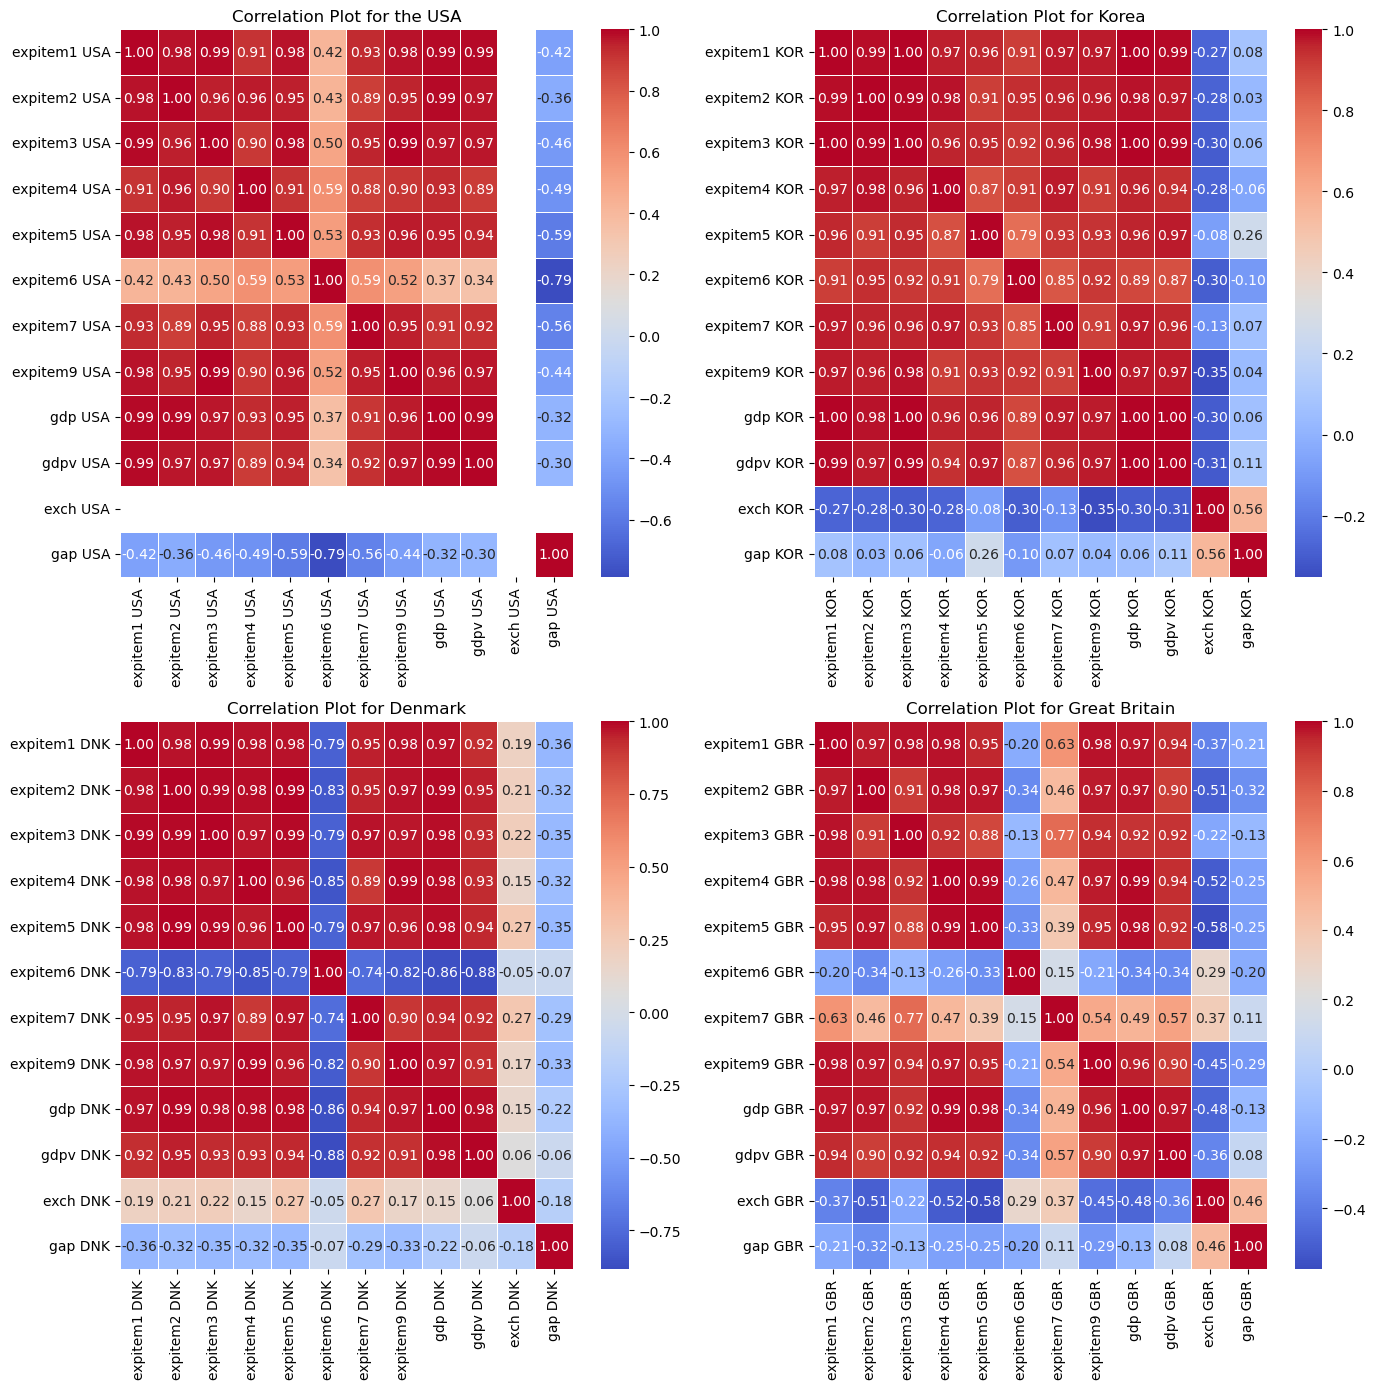

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the overall figure siz
plt.figure(figsize=(14, 14))

# Correlation Matrix for USA
plt.subplot(2, 2, 1)
USA_vars = ['expitem1 USA', 'expitem2 USA', 'expitem3 USA', 'expitem4 USA', 'expitem5 USA', 'expitem6 USA', 'expitem7 USA', 'expitem9 USA', 'gdp USA', 'gdpv USA', 'exch USA', 'gap USA']
USA_df = df[USA_vars]
correlation_matrix = USA_df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title("Correlation Plot for the USA")

# Correlation Matrix for KOR
plt.subplot(2, 2, 2)
KOR_vars = ['expitem1 KOR', 'expitem2 KOR', 'expitem3 KOR', 'expitem4 KOR', 'expitem5 KOR', 'expitem6 KOR', 'expitem7 KOR', 'expitem9 KOR', 'gdp KOR', 'gdpv KOR', 'exch KOR', 'gap KOR']
KOR_df = df[KOR_vars]
correlation_matrix = KOR_df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title("Correlation Plot for Korea")

# Correlation Matrix for DNK
plt.subplot(2, 2, 3)
DNK_vars = ['expitem1 DNK', 'expitem2 DNK', 'expitem3 DNK', 'expitem4 DNK', 'expitem5 DNK', 'expitem6 DNK', 'expitem7 DNK', 'expitem9 DNK', 'gdp DNK', 'gdpv DNK', 'exch DNK', 'gap DNK']
DNK_df = df[DNK_vars]
correlation_matrix = DNK_df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title("Correlation Plot for Denmark")

# Correlation Matrix for Great Britain
plt.subplot(2, 2, 4)
GBR_vars = ['expitem1 GBR', 'expitem2 GBR', 'expitem3 GBR', 'expitem4 GBR', 'expitem5 GBR', 'expitem6 GBR', 'expitem7 GBR', 'expitem9 GBR', 'gdp GBR', 'gdpv GBR', 'exch GBR', 'gap GBR']
GBR_df = df[GBR_vars]
correlation_matrix = GBR_df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title("Correlation Plot for Great Britain")

plt.tight_layout()

plt.show()


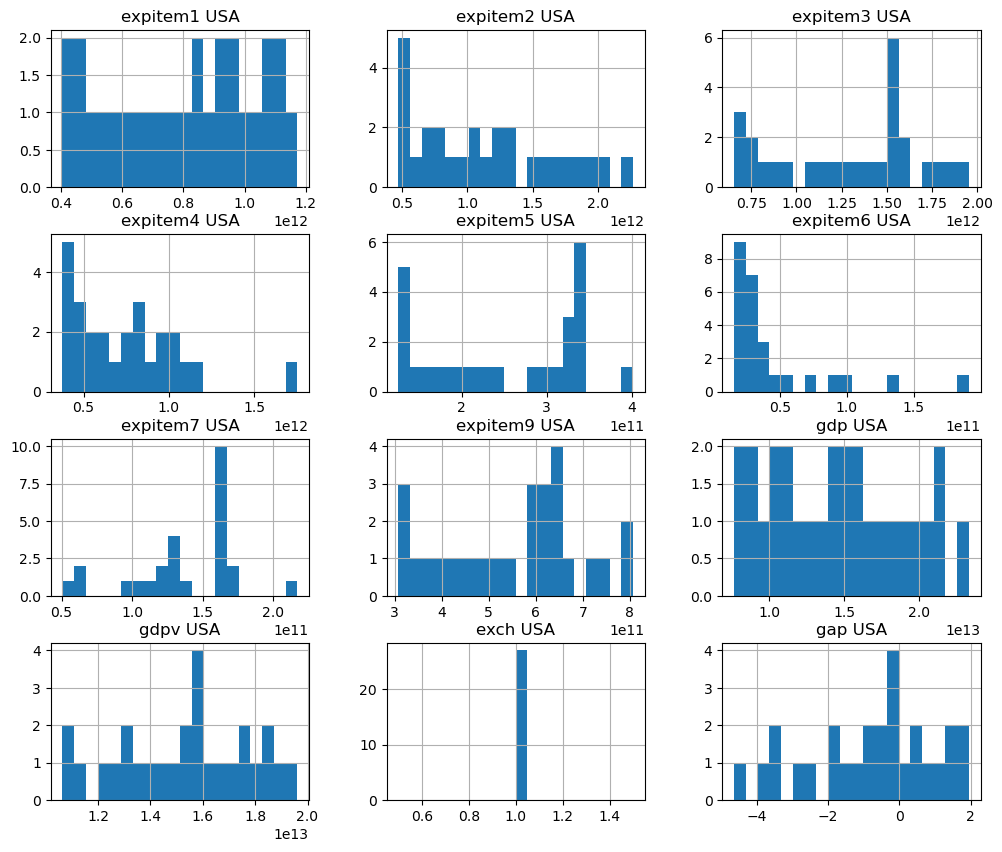

In [11]:
# USA Variables Histogram
USA_df.hist(figsize=(12, 10), bins=20)
plt.show()

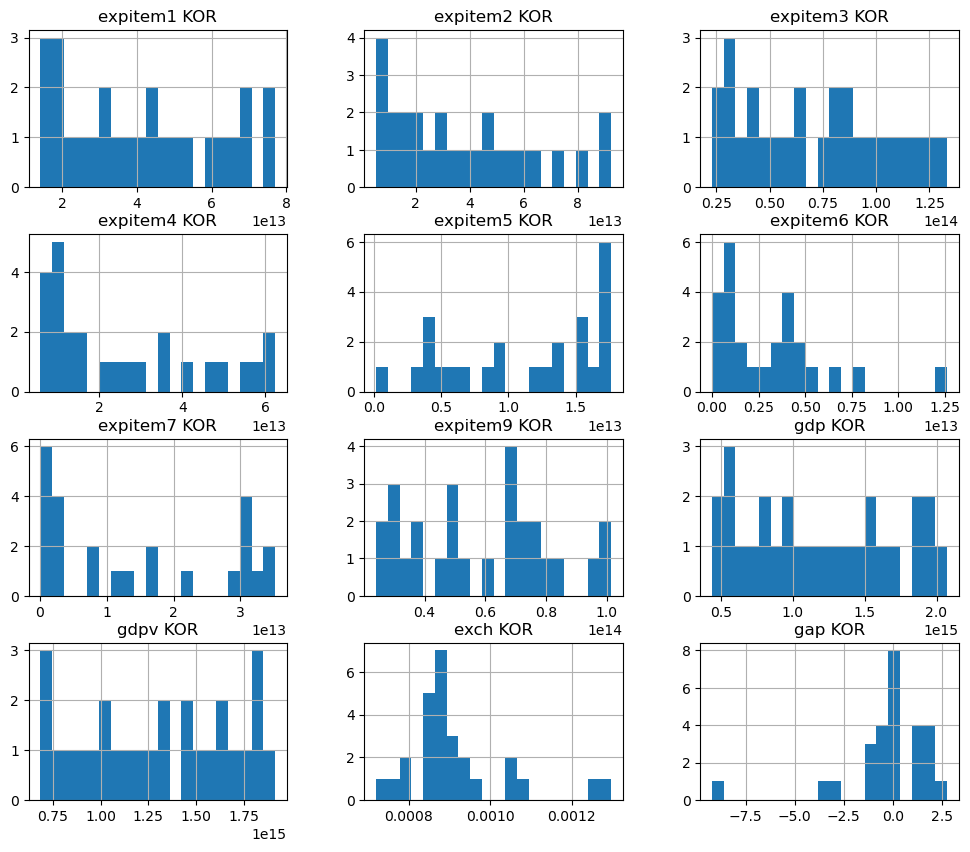

In [12]:
# KOR Variables Histogram
KOR_df.hist(figsize=(12, 10), bins=20)
plt.show()

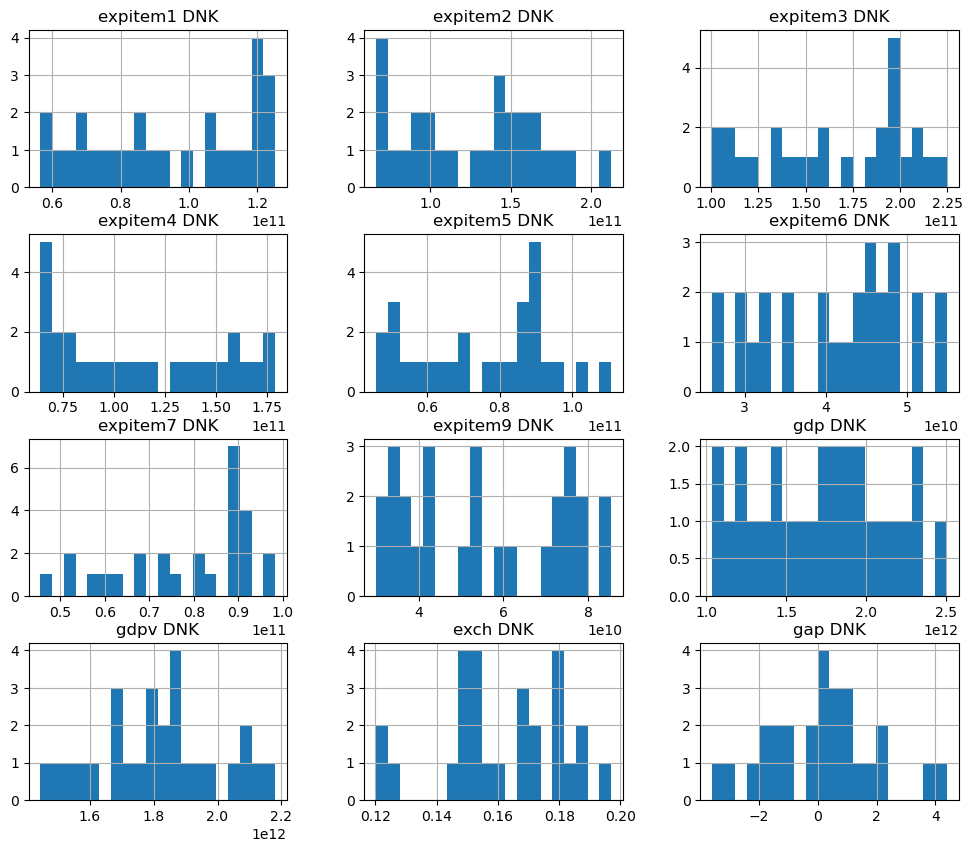

In [13]:
# DENMARK Variables Histogram
DNK_df.hist(figsize=(12, 10), bins=20)
plt.show()

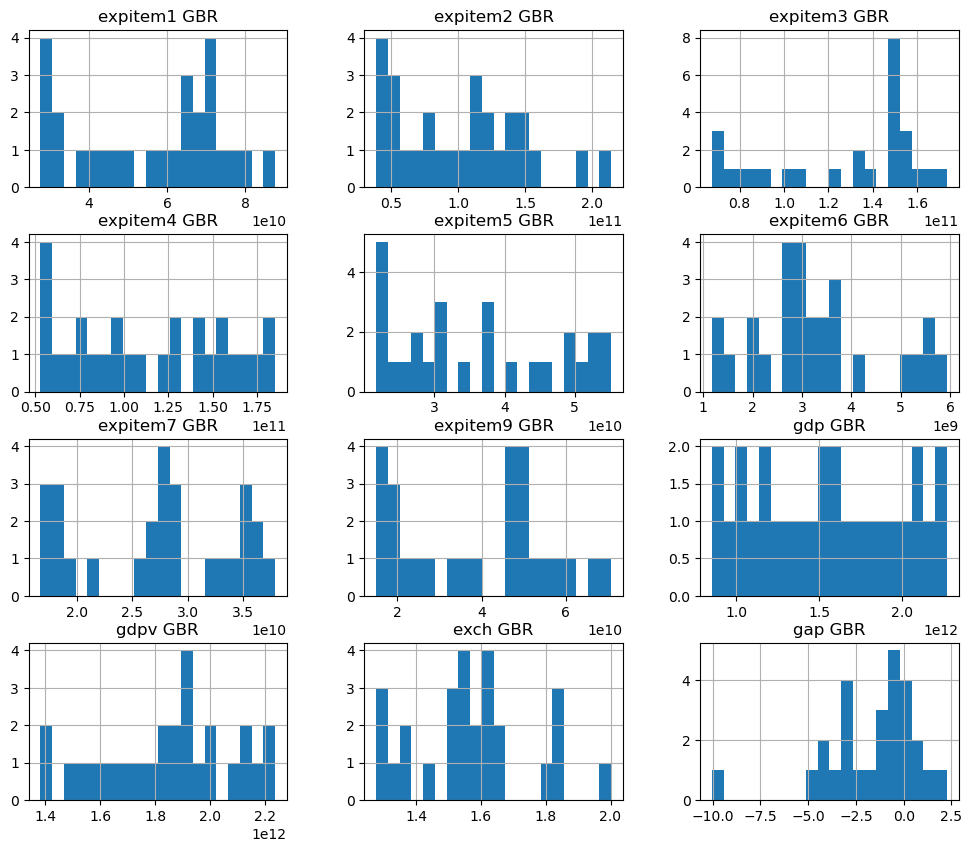

In [14]:
# Great Britain Variables Histogram
GBR_df.hist(figsize=(12, 10), bins=20)
plt.show()

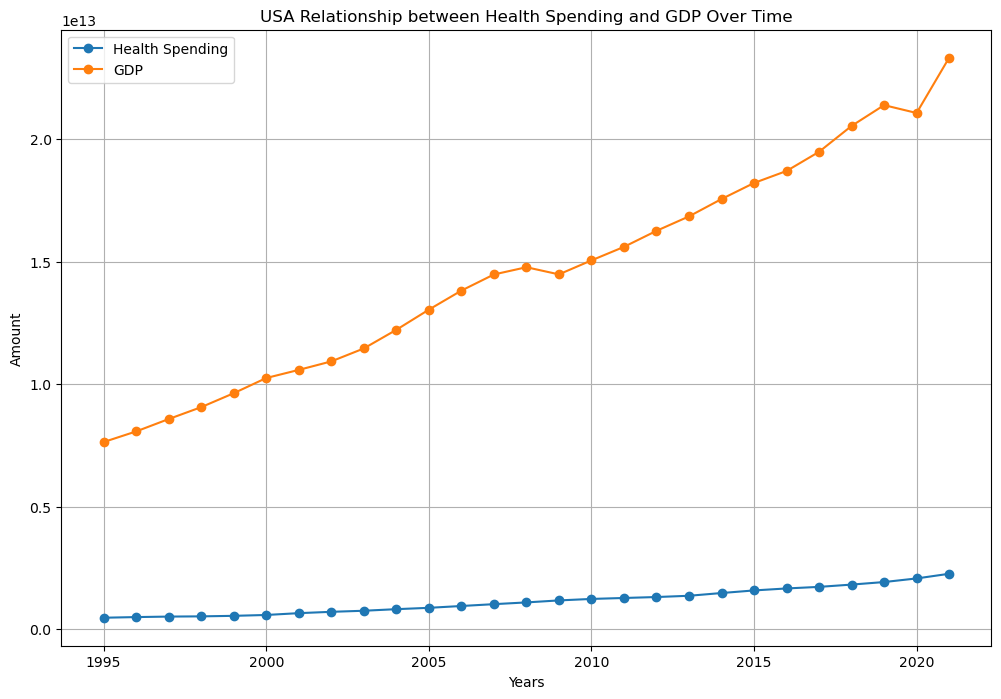

In [15]:
# Health Spending v GDP over time USA
plt.figure(figsize=(12, 8))

# Plotting 'health spending' over time
plt.plot(df['year'], df['expitem2 USA'], marker='o', linestyle='-', label='Health Spending')

# Plotting 'gdp' over time
plt.plot(df['year'], df['gdp USA'], marker='o', linestyle='-', label='GDP')

plt.title('USA Relationship between Health Spending and GDP Over Time')
plt.xlabel('Years')
plt.ylabel('Amount')
plt.legend()
plt.grid(True)
plt.show()

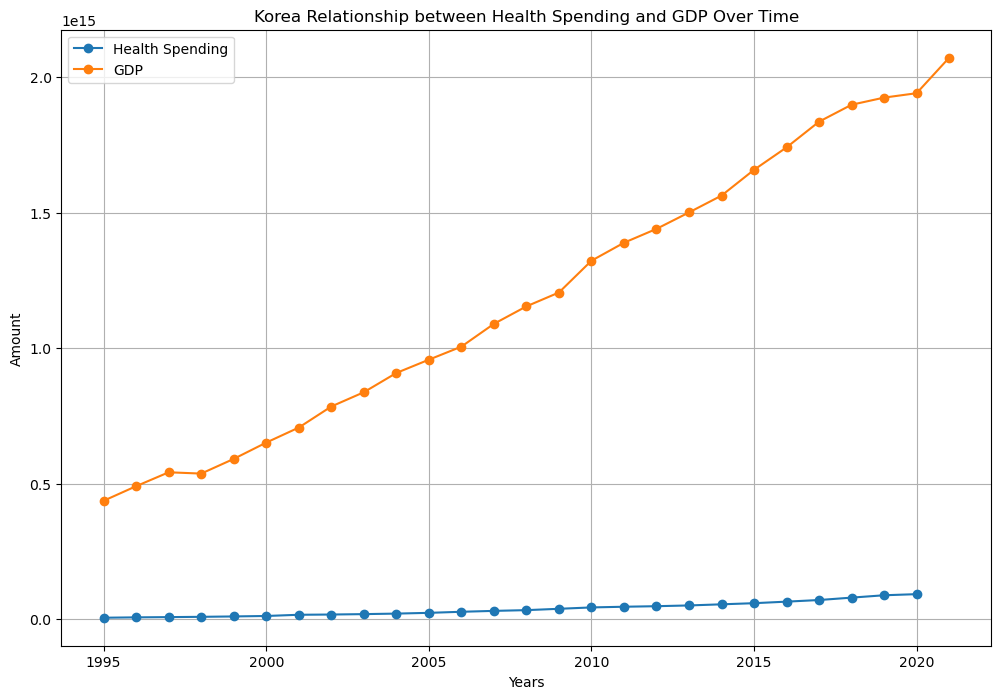

In [16]:
# Health Spending v GDP over time KOREA
plt.figure(figsize=(12, 8))

# Plotting 'health spending' over time
plt.plot(df['year'], df['expitem2 KOR'], marker='o', linestyle='-', label='Health Spending')

# Plotting 'gdp' over time
plt.plot(df['year'], df['gdp KOR'], marker='o', linestyle='-', label='GDP')

plt.title('Korea Relationship between Health Spending and GDP Over Time')
plt.xlabel('Years')
plt.ylabel('Amount')
plt.legend()
plt.grid(True)
plt.show()

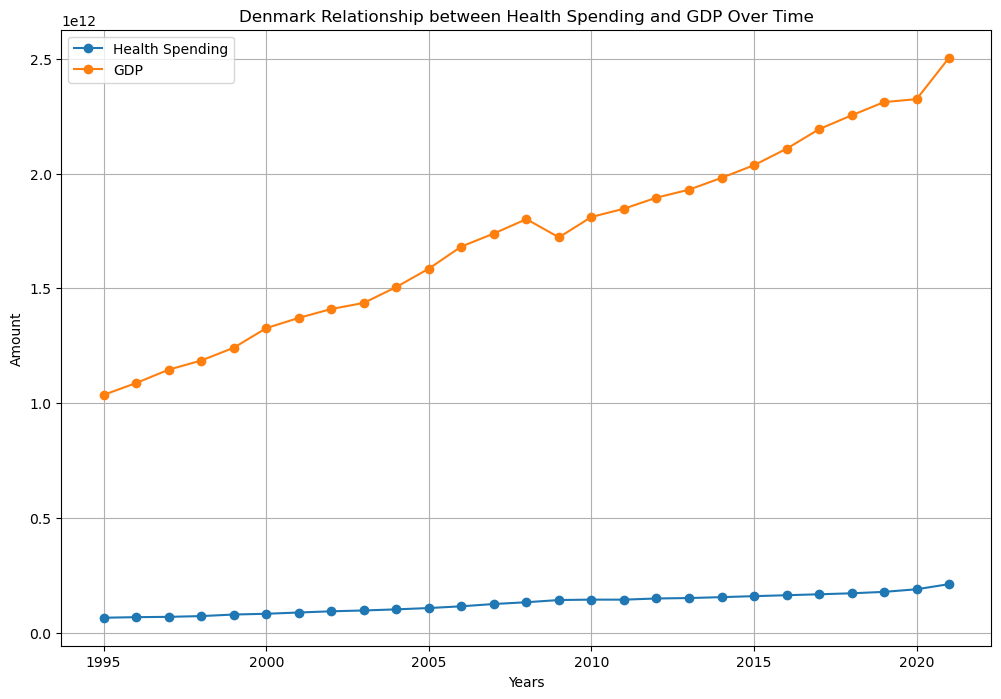

In [17]:
# Health Spending v GDP over time Denmark
plt.figure(figsize=(12, 8))

# Plotting 'health spending' over time
plt.plot(df['year'], df['expitem2 DNK'], marker='o', linestyle='-', label='Health Spending')

# Plotting 'gdp' over time
plt.plot(df['year'], df['gdp DNK'], marker='o', linestyle='-', label='GDP')

plt.title('Denmark Relationship between Health Spending and GDP Over Time')
plt.xlabel('Years')
plt.ylabel('Amount')
plt.legend()
plt.grid(True)
plt.show()

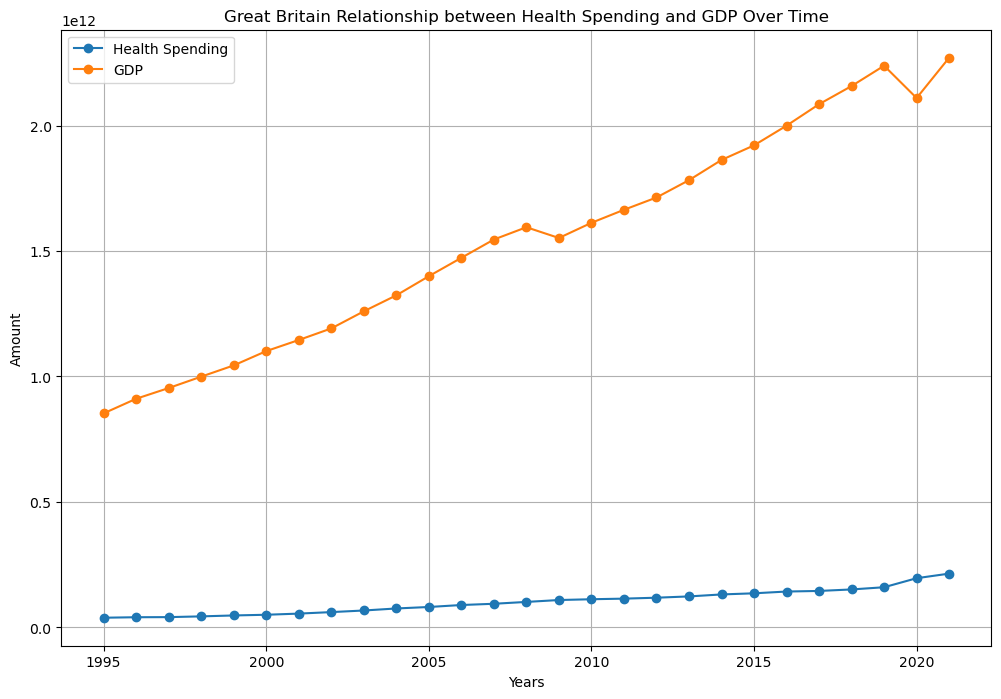

In [18]:
# Health Spending v GDP over time GBR
plt.figure(figsize=(12, 8))

# Plotting 'health spending' over time
plt.plot(df['year'], df['expitem2 GBR'], marker='o', linestyle='-', label='Health Spending')

# Plotting 'gdp' over time
plt.plot(df['year'], df['gdp GBR'], marker='o', linestyle='-', label='GDP')

plt.title('Great Britain Relationship between Health Spending and GDP Over Time')
plt.xlabel('Years')
plt.ylabel('Amount')
plt.legend()
plt.grid(True)
plt.show()

We see that in the correlation plots, most of the variables are correlated with each other, except for expitem6 (unemployment benefits) and the other variables in the data set for the countries DNK, GRB, and USA. This leads us to consider the potential of exploring the relationship between unemployment benefits, GDP, and health spending. It also appears that in DNK (Denmark), unemployment benefits are negatively correlated with GDP, while in USA, unemployment benefits have a relatively weak positive correlatioin with GDP. 

For the variable histograms for each country, the x-axis is the possible outcomes, and the y-axis is the frequency of each outcome. If we look at the 'gap' variable (total output gap), we notice that the USA, KOR, DNK, and GBR all have varying output gap over the specified time period. A negative outcome bad reflects an economy that is not meeting its full potential, so we can compare the health spending of years with negative output gaps with that of years with positive output gaps to gauge the state of the economy given health spending that year. 

**Introducing a New Dataset and Futher Cleaning**

After performing some inital EDA on the OECD Public finance dataset, we realized that in our original dataset, there is no direct measurement of health outcomes. We likewise felt that using GDP or GDP per capita as a proxy for health did not seem relevant as our primary dataset neither recorded GDP per capita nor population by year per country. Luckily, we were able to locate an additional dataset on OECD countries' health statistics from 1960s to today that followed a time series format. From that dataset, we decided that life expectancy would be a good indicator for a country's health outcomes. We then proeeded in merging the primary dataset with our secondary one. 

Similarly to our initial issues with the OECD Punlic Finance dataset, times existed when countries within the Life Expectancy dataset also had NaN values for differing reasons. Rather than truncating the dataset, we first attempted to use KNN imputation to fill in all the numerical NaN values in our merged dataframe. Note that we chose to use KNN instead of simple mean because countries' statistics are usually more similar across short time spans, but may be very different across the entire time frame of our data set. In practice, though, the fact that we chose a time series dataset with many indicides meant that, in practice, it imputed a cell using information from another country in cases where missing cells were between at the beginning of each country's data and the end of another's at a different time period. Take, for example, The USA data above Maxico: The USA would end with 2021 complete data, and sit next to Mexico, which would have NaN values in 1995, or modified starting point for our project. KNN imputation would pull USA data to predict Mexico's data. 

Since we wanted to acknowledge each country and the size out a country's economy, we manually exported the csv and filled NaN values with the most recent values avaliable at a given time. In the Mexico-USA example, Mexico would use it's 1996 data for 1995 rather than the US' 2021 data, which we viewed as more fitting:

In [19]:
# Load datasets
df_health_spending = pd.read_csv('CS109acleandata.csv')  
df_life_expectancy = pd.read_csv('CS109alifeexpectancytotal.csv')  

# Preprocess life expectancy dataset
# Filter for years 1995-2021
df_life_expectancy = df_life_expectancy[(df_life_expectancy['TIME'] >= 1995) & (df_life_expectancy['TIME'] <= 2021)]

# Exclude specific countries
countries_to_exclude = ['CAN', 'CHL', 'COL', 'CRI', 'CZE', 'MEX', 'NZL', 'TUR']
df_life_expectancy = df_life_expectancy[~df_life_expectancy['LOCATION'].isin(countries_to_exclude)]

# Merge datasets
df_merged = pd.merge(df_health_spending, df_life_expectancy, how='inner', left_on=['iso3', 'year'], right_on=['LOCATION', 'TIME'])

# Convert expediture items to % gdp
expend = ['expitem1', 'expitem2','expitem3', 'expitem4', 'expitem5', 'expitem6', 
          'expitem7', 'expitem8', 'expitem9', 'expitem10', 'expitem11']
for exp in expend:
    df_merged[exp] = df_merged[exp]/df_merged['gdp']

# Drop non-expenditure related items
df_merged = df_merged.drop(columns=['revitem1', 'revitem10', 'revitem2', 'revitem3', 'revitem4', 'revitem5', 
                                    'revitem6', 'revitem7', 'revitem8', 'revitem9', 'gdp', 'gdpv', 'cpi', 'exch', 
                                    'gap', 'nlgq', 'nlgqa', 'ypg', 'ypga', 'yrg', 'yrga', 'ggflm', 'LOCATION', 
                                    'INDICATOR', 'MEASURE', 'FREQUENCY', 'SUBJECT', 'TIME', 'Flag Codes'])

df_merged = df_merged.rename(columns={'Value':'Life_exp'})

In [20]:
from pathlib import Path  
filepath = Path('merged.csv')  
filepath.parent.mkdir(parents=True, exist_ok=True)  
df_merged.to_csv(filepath, index=False)  

In [3]:
df_merged = pd.read_csv("remerged.csv")
df_merged

,iso3,year,expitem1,expitem10,expitem11,expitem2,expitem3,expitem4,expitem5,expitem6,expitem7,expitem8,expitem9,Life_exp
0,AUS,1995,0.046360,-0.001482,0.025830,0.053746,0.102643,0.038685,0.035069,0.006933,0.035763,0.012358,0.029159,77.8
1,AUS,1996,0.046360,-0.001482,0.022254,0.053746,0.102643,0.038685,0.035069,0.006933,0.035763,0.012781,0.028581,78.1
2,AUS,1997,0.046360,-0.001482,0.017414,0.053746,0.102643,0.038685,0.035069,0.006933,0.035763,0.011692,0.030113,78.4
3,AUS,1998,0.046360,-0.001482,0.014203,0.053746,0.102643,0.038685,0.035069,0.006933,0.035763,0.012251,0.028713,78.6
4,AUS,1999,0.046592,-0.003449,0.012410,0.055136,0.101461,0.038598,0.036693,0.007031,0.038151,0.011963,0.028327,78.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
824,USA,2017,0.054302,0.010546,0.039412,0.088904,0.082814,0.054204,0.017139,0.001211,0.008412,0.003074,0.034310,78.6
825,USA,2018,0.053358,0.009857,0.040315,0.088880,0.082994,0.054045,0.016426,0.001061,0.008197,0.003084,0.034668,78.7
826,USA,2019,0.052642,0.009722,0.041566,0.090214,0.083952,0.055354,0.015877,0.001155,0.007943,0.003412,0.035130,78.8
827,USA,2020,0.053329,0.015475,0.039149,0.098564,0.088243,0.083230,0.019050,0.009071,0.010304,0.031209,0.037535,77.0


Above is the result of our cleaned dataset, with clear examples of how we filled NaN values. For a clear example, see observations 0-10 in the expitem1 variable. Then, we were able to proceed with linear regression.

**Linear Regression**

Not yet having a clear idea of health outcome's relationship with government expenditures, we intended to further explore the data by taking a stepwise approach in complexity. In practice, this would involve starting with a simple linear regression model with life expectenacy at birth was the independent variable. To narriow down the amount of modeling we did, we hypothesised healcarespending as a possible predictor. Our hope is that this naive assumption will give us a baseline understanding of the direct relationship between the two variables, which we have yet to explore outside of corellation.

Note that simple linear regression likewise does not allow for modeling on time series datasets, meaning we needed to fix one of our indicies again. We chose country, and relationships over time were more relevant to us than relationships between countries at a given time. We chose to keep the original set of 4 diverse countries we outlined above to proceed with:

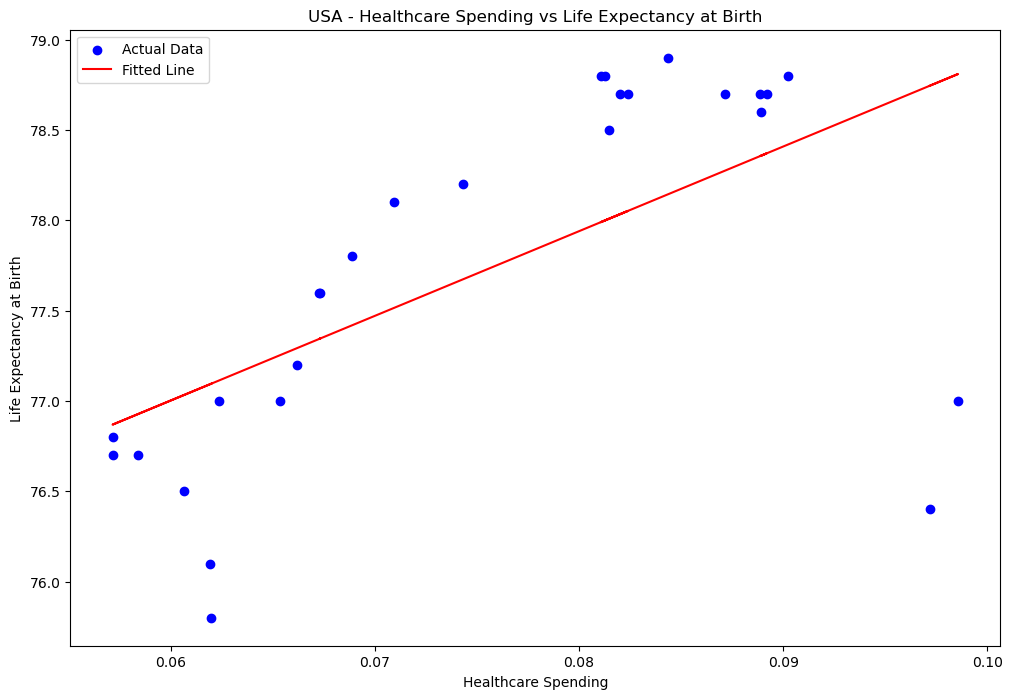

USA - Mean squared error: 0.6063466504992469
USA - R-squared value: 0.3649771459976574


In [4]:
# Linear regression USA

usa_data = df_merged[df_merged['iso3'] == 'USA']
X_usa = usa_data[['expitem2']].values.reshape(-1, 1)  # Health spending
y_usa = usa_data['Life_exp'].values  # Life expectancy

# Create and fit linear regression model for USA
model_usa = LinearRegression()
model_usa.fit(X_usa, y_usa)

# Plot USA data and regression line
plt.figure(figsize=(12, 8))
plt.scatter(X_usa, y_usa, color='blue', label='Actual Data')
plt.plot(X_usa, model_usa.predict(X_usa), color='red', label='Fitted Line')
plt.title('USA - Healthcare Spending vs Life Expectancy at Birth')
plt.xlabel('Healthcare Spending')
plt.ylabel('Life Expectancy at Birth')
plt.legend()
plt.show()

# Use model to make predictions for USA
y_pred_usa = model_usa.predict(X_usa)

# Calculate and print mean squared error and R-squared value for USA
mse_usa = mean_squared_error(y_usa, y_pred_usa)
r2_usa = r2_score(y_usa, y_pred_usa)

print(f"USA - Mean squared error: {mse_usa}")
print(f"USA - R-squared value: {r2_usa}")

The MSE for the USA linear regression model is approximately 0.6063, which means that the average squared difference between the predicted life expectancy and the actual life expectancy is 0.606 years squared. The lower the MSE, the better the model's predictions match the actual data. However, without context (such as the range of life expectancy values), it's difficult to assess whether this MSE indicates a good fit. For instance, if life expectancy varies between 75 and 85 years, an MSE of 0.606 might indicate a reasonably good fit. But if the life expectancy only varies from 77 to 78 years, an MSE of 0.606 would indicate a poor fit. 

In the cause of the USA's simple linear regression model, the observed range for life expectqancy is from 75 to 79, indidcating a generally good fit.

The R-squared value for the USA is approximately 0.365, which means that about 36.5% of the variance in life expectancy can be explained by the model's inputs. An R-squared of 0.365 indicates a low to moderate level of explanatory power. While an R-squared of 0.365 suggests that the model has captured some of the variability in life expectancy, a significant portion of the variability (more than 60%) is still unexplained by the model. This might be due to other factors affecting life expectancy that are not included in the model, or it could be because the relationship between the predictors and life expectancy is not perfectly linear.

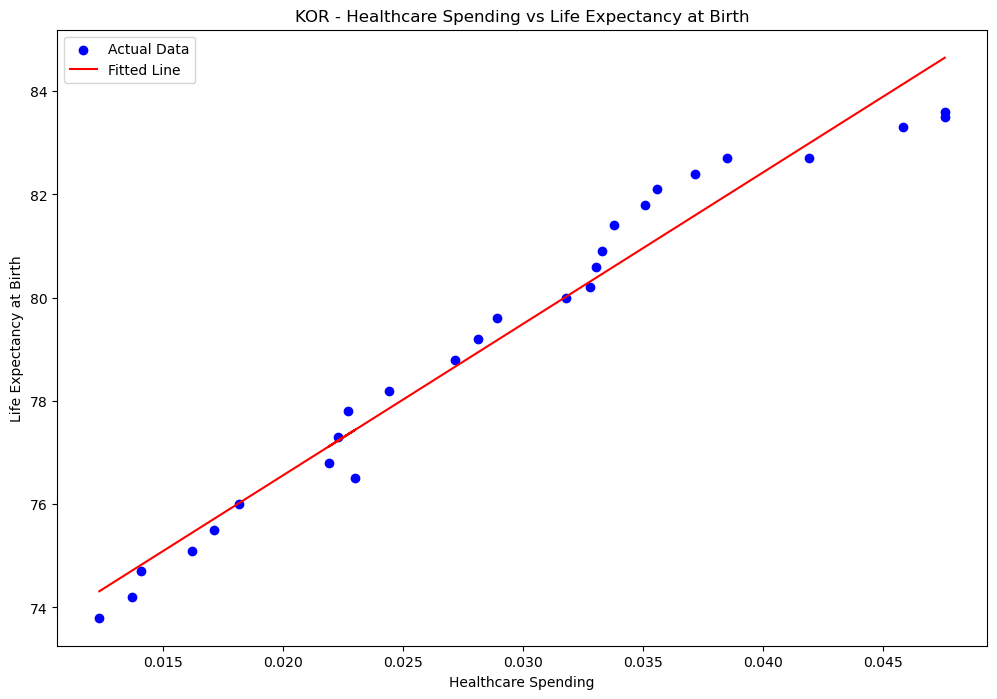

KOR - Mean squared error: 0.33869993818289107
KOR - R-squared value: 0.9635642066075035


In [5]:
# Linear regression KOR
# Filter the merged dataframe for KOR
kor_data = df_merged[df_merged['iso3'] == 'KOR']
X_kor = kor_data[['expitem2']].values.reshape(-1, 1)  # Health spending
y_kor = kor_data['Life_exp'].values  # Life expectancy

# Create and fit linear regression model for KOR
model_kor = LinearRegression()
model_kor.fit(X_kor, y_kor)

# Plot KOR data and regression line
plt.figure(figsize=(12, 8))
plt.scatter(X_kor, y_kor, color='blue', label='Actual Data')
plt.plot(X_kor, model_kor.predict(X_kor), color='red', label='Fitted Line')
plt.title('KOR - Healthcare Spending vs Life Expectancy at Birth')
plt.xlabel('Healthcare Spending')
plt.ylabel('Life Expectancy at Birth')
plt.legend()
plt.show()

# Use model to make predictions for KOR
y_pred_kor = model_kor.predict(X_kor)

# Calculate and print the mean squared error and R-squared value for KOR
mse_kor = mean_squared_error(y_kor, y_pred_kor)
r2_kor = r2_score(y_kor, y_pred_kor)

print(f"KOR - Mean squared error: {mse_kor}")
print(f"KOR - R-squared value: {r2_kor}")

The MSE is quite lower than that of the USA at approximately 0.3387. On average, the model's predictions deviate from the actual observed life expectancy values by the square root of this MSE value. The square root of 0.3386 is around 0.5818, which suggests a deviation of about 0.5818 years from the true life expectancy values. A lower MSE indicates that the model's predictions are less accurate on average compared to the USA model, but this metric alone doesn't provide the complete picture without comparing it to the range and distribution of life expectancy values in South Korea.

The R-squared value of approximately 0.9635 for South Korea is substantially higher than the USA's R-squared value. We could anticpate a value closer to one by virtue of the linear model being so close the the observed values. This indicates that the model explains around 96.4% of the variance in life expectancy in South Korea, which is a significant portion. A higher R-squared value suggests that the model fits the data better and the independent variables used in the model are more effective at explaining the variation in life expectancy for South Korea compared to the USA. An R-squared value of 0.664 indicates that the model has a moderate to high level of predictive power, but as with all models, it is important to consider the context and other potential variables that could improve the model's explanatory power.

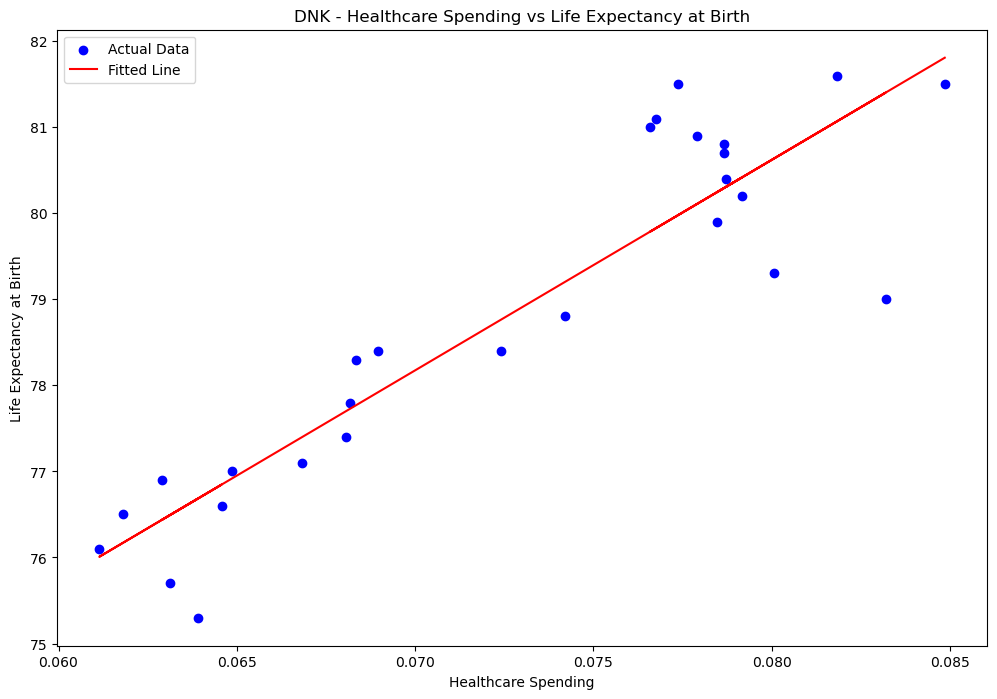

DNK - Mean squared error: 0.6863208605029868
DNK - R-squared value: 0.8203116242137762


In [6]:
# Linear regression DNK

# Filter merged dataframe for DNK
dnk_data = df_merged[df_merged['iso3'] == 'DNK']
X_dnk = dnk_data[['expitem2']].values.reshape(-1, 1)  # Health spending
y_dnk = dnk_data['Life_exp'].values  # Life expectancy

# Create and fit linear regression model for DNK
model_dnk = LinearRegression()
model_dnk.fit(X_dnk, y_dnk)

# Plot the DNK data and regression line
plt.figure(figsize=(12, 8))
plt.scatter(X_dnk, y_dnk, color='blue', label='Actual Data')
plt.plot(X_dnk, model_dnk.predict(X_dnk), color='red', label='Fitted Line')
plt.title('DNK - Healthcare Spending vs Life Expectancy at Birth')
plt.xlabel('Healthcare Spending')
plt.ylabel('Life Expectancy at Birth')
plt.legend()
plt.show()

# Use the model to make predictions for DNK
y_pred_dnk = model_dnk.predict(X_dnk)

# Calculate and print mean squared error and R-squared value for DNK
mse_dnk = mean_squared_error(y_dnk, y_pred_dnk)
r2_dnk = r2_score(y_dnk, y_pred_dnk)

print(f"DNK - Mean squared error: {mse_dnk}")
print(f"DNK - R-squared value: {r2_dnk}")

An MSE of about 0.6863 indicates that the model's predictions a relativey good fit to the observed values. In this case, the square root of 0.6863 is approximately 0.8284, suggesting that the model's predictions are, on average, deviating from the actual life expectancy by only about 0.8284 years. 


An R-squared value of 0.8203 is extremely high and indicates that the model explains about 82.03% of the variance in life expectancy in Denmark. This means that the independent variables selected for the model are very effective at predicting life expectancy outcomes. Such a high R-squared value often indicates a very good fit of the model to the data. However, it is also important to be cautious of overfitting, where the model might be too closely tailored to the sample data and may not generalize well to unseen data.

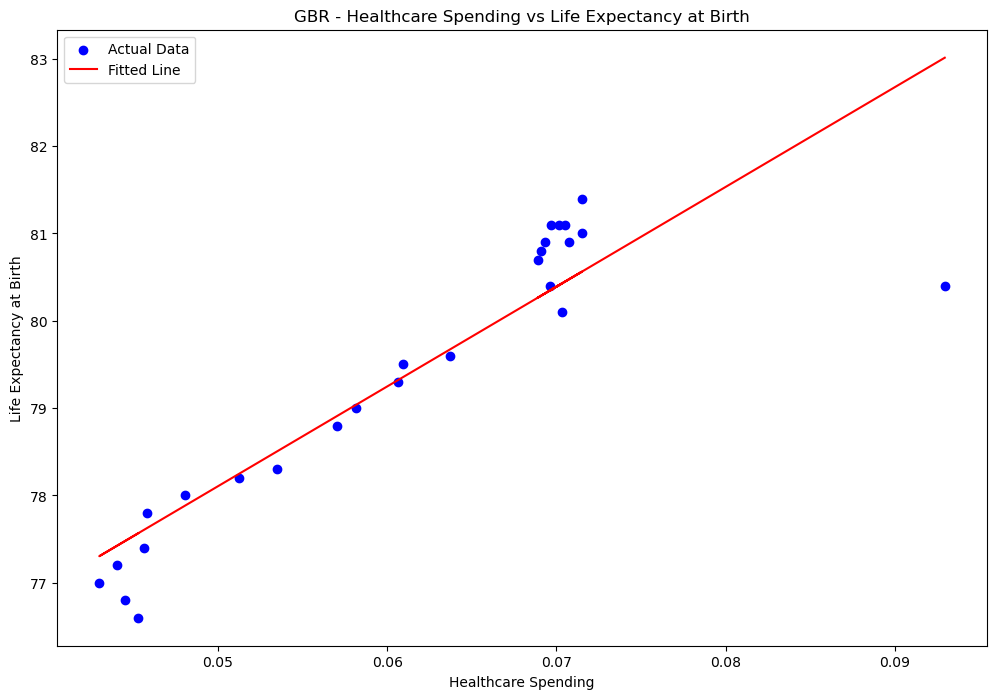

GBR - Mean squared error: 0.46021751927115867
GBR - R-squared value: 0.8094080553890762


In [7]:
# Filter merged dataframe for GBR
gbr_data = df_merged[df_merged['iso3'] == 'GBR']
X_gbr = gbr_data[['expitem2']].values.reshape(-1, 1)  # Health spending
y_gbr = gbr_data['Life_exp'].values  # Life expectancy

# Create and fit linear regression model for GBR
model_gbr = LinearRegression()
model_gbr.fit(X_gbr, y_gbr)

# Create and fit linear regression model for GBR
model_gbr = LinearRegression()
model_gbr.fit(X_gbr, y_gbr)

# Plot GBR data and regression line
plt.figure(figsize=(12, 8))
plt.scatter(X_gbr, y_gbr, color='blue', label='Actual Data')
plt.plot(X_gbr, model_gbr.predict(X_gbr), color='red', label='Fitted Line')
plt.title('GBR - Healthcare Spending vs Life Expectancy at Birth')
plt.xlabel('Healthcare Spending')
plt.ylabel('Life Expectancy at Birth')
plt.legend()
plt.show()

# Use model to make predictions for GBR
y_pred_gbr = model_gbr.predict(X_gbr)

# Calculate and print mean squared error and R-squared value for GBR
mse_gbr = mean_squared_error(y_gbr, y_pred_gbr)
r2_gbr = r2_score(y_gbr, y_pred_gbr)

print(f"GBR - Mean squared error: {mse_gbr}")
print(f"GBR - R-squared value: {r2_gbr}")

An MSE of around 0.4602 indicates that the predictions of the model are fairly close to the actual life expectancy values. The square root of the MSE gives the root mean square error (RMSE), which in this case is approximately 0.6783 years. This suggests that, on average, the model's predictions deviate from the observed life expectancy by less than 0.6 years.

The R-squared value of 0.8094 for Great Britain implies that the model explains about 80.94% of the variance in life expectancy, which is a strong indication of the model's effectiveness. This high R-squared value suggests that the independent variables chosen for the model provide a good explanation of the changes in life expectancy and that the model has a high predictive power for the data at hand.


In summary, the evaluation of linear regression models for predicting life expectancy across different countries reveals varied levels of predictive accuracy and explanatory power. For the USA, with an MSE of 0.6063 and an R-squared value of 0.365, the model shows a generally good fit, especially considering the observed life expectancy range of 75 to 79 years. However, the relatively low R-squared value indicates that a significant portion of variability in life expectancy is not captured by the model.

Comparatively, South Korea's model demonstrates superior performance with an R-squared value of 0.9635, suggesting a high level of explanatory power and a strong fit, as the model accounts for about 96.4% of the variance in life expectancy. The MSE of 0.3387, lower than that of the USA, also points to a more accurate model in terms of prediction.

Denmark's model exhibits an even higher level of predictive accuracy, with an R-squared value of 0.8203, indicating that about 82% of the variance in life expectancy is explained by the model. The MSE of 0.4602, yielding an RMSE of approximately 0.6783 years, confirms the close fit of the model predictions to the actual values, although the risk of overfitting should be considered.

Great Britain's model, with an R-squared value of 0.8094, similarly demonstrates strong predictive power, explaining about 81% of the variance in life expectancy. This high R-squared value, coupled with the model's explanatory variables, suggests a robust model performance.

Overall, these analyses underscore the importance of considering both MSE and R-squared values in assessing the effectiveness of regression models. While lower MSEs indicate more accurate predictions, higher R-squared values reflect a model's ability to explain the variability in the data. The context, such as the range of life expectancy values, remains crucial in interpreting these metrics and their implications for model fit and predictive power. These findings underscore the complexity of the relationship between healthcare spending and life expectancy, with the models capturing key aspects of this relationship to varying degrees across different national contexts as such, a logical step up would then seek to explore ther relationship from a causal perspective:


**Causal Analysis: Country and Year Fixed Effects**

We then conducted a further analysis of our data, incorporating both country and year as fixed effects. This was achieved through a regression on overall life expectancy, utilizing One-hot-encoding facilitated by Statmodels with the goal of undercovering some causal relationship between our predictors and response variable. To mitigate the variance in spending between smaller and larger countries, we employed the logarithm of the numerical predictor:

In [8]:
naive = smf.ols(formula='Life_exp ~ 1 + np.log(expitem2)',data=df_merged).fit(cov_type='HC1')
naive.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Life_exp   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     3.279
Date:                Thu, 14 Dec 2023   Prob (F-statistic):             0.0705
Time:                        17:25:06   Log-Likelihood:                -2174.1
No. Observations:                 829   AIC:                             4352.
Df Residuals:                     827   BIC:                             4362.
Df Model:                           1                                         
Covariance Type:                  HC1                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           80.0602      0.659    121.499      0.000      78.769      81.352
np.log(expitem2)     0.4094      0.226      1.811      0.070      -0.034       0.852
==============================================================================
Omnibus:                       58.579   Durbin-Watson:                   0.186
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               70.131
Skew:                          -0.710   Prob(JB):                     5.90e-16
Kurtosis:                       2.879   Cond. No.                         15.8
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
"""

We first looked at the naive regression of life expectancy using only health expenditures, shown above. We see that the intercept is at 80, meaning that <mark>without health expenditures, the average life expectancy is 80 years</mark>. The coefficient on health expenditures is 0.41, meaning that <mark>for every 1% increase in health expenditures as percent of GDP, life expenctacy is expected to go up by 0.4 years</mark>. 

Overall, though, the simple regression analysis suggests a marginal and statistically non-significant association between health expenditures and life expectancy, with the model explaining less than 1% of the variance in life expectancy. The low R-squared values and the lack of statistical significance at the 5% level for the expenditure coefficient indicate that the model, as it stands, does not adequately capture the relationship between health expenditures and life expectancy fully. Model diagnostics further imply that the residuals do not follow a normal distribution, hinting at potential issues with model assumptions or missing factors that could influence life expectancy, which is expected given there are definitely confounding factors excluded from our dataset that effect life expectancy.

In [9]:
country_fixed = smf.ols(formula='Life_exp ~ 1 + np.log(expitem2) + C(iso3)',data=df_merged).fit(cov_type='HC1')
country_fixed.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Life_exp   R-squared:                       0.797
Model:                            OLS   Adj. R-squared:                  0.789
Method:                 Least Squares   F-statistic:                     94.34
Date:                Thu, 14 Dec 2023   Prob (F-statistic):          1.21e-242
Time:                        17:25:06   Log-Likelihood:                -1515.9
No. Observations:                 829   AIC:                             3096.
Df Residuals:                     797   BIC:                             3247.
Df Model:                          31                                         
Covariance Type:                  HC1                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           99.5355      1.477     67.399      0.000      96.641     102.430
C(iso3)[T.AUT]      -1.2360      0.310     -3.983      0.000      -1.844      -0.628
C(iso3)[T.BEL]      -1.7818      0.277     -6.427      0.000      -2.325      -1.238
C(iso3)[T.BGR]      -4.7223      0.447    -10.557      0.000      -5.599      -3.846
C(iso3)[T.CHE]      24.0284      2.069     11.615      0.000      19.974      28.083
C(iso3)[T.DEU]      -1.7148      0.278     -6.175      0.000      -2.259      -1.171
C(iso3)[T.DNK]      -3.1723      0.338     -9.399      0.000      -3.834      -2.511
C(iso3)[T.ESP]       1.0542      0.327      3.221      0.001       0.413       1.696
C(iso3)[T.EST]      -4.5033      0.604     -7.458      0.000      -5.687      -3.320
C(iso3)[T.FIN]      -1.3121      0.309     -4.246      0.000      -1.918      -0.707
C(iso3)[T.FRA]      -0.8903      0.312     -2.856      0.004      -1.501      -0.279
C(iso3)[T.GBR]      -1.3620      0.223     -6.115      0.000      -1.799      -0.926
C(iso3)[T.GRC]       0.0111      0.301      0.037      0.970      -0.579       0.601
C(iso3)[T.HUN]      -5.4900      0.501    -10.953      0.000      -6.472      -4.508
C(iso3)[T.IRL]      -0.6642      0.514     -1.292      0.196      -1.672       0.343
C(iso3)[T.ISL]      -0.6976      0.353     -1.975      0.048      -1.390      -0.005
C(iso3)[T.ISR]       1.5999      0.400      4.003      0.000       0.816       2.383
C(iso3)[T.ITA]       0.5462      0.268      2.041      0.041       0.022       1.071
C(iso3)[T.JPN]       1.2807      0.248      5.172      0.000       0.795       1.766
C(iso3)[T.KOR]       3.7665      0.503      7.488      0.000       2.781       4.752
C(iso3)[T.LTU]      -6.1060      0.448    -13.633      0.000      -6.984      -5.228
C(iso3)[T.LUX]       1.8142      0.479      3.786      0.000       0.875       2.753
C(iso3)[T.LVA]      -3.4773      0.586     -5.931      0.000      -4.626      -2.328
C(iso3)[T.NLD]      -0.6594      0.212     -3.116      0.002      -1.074      -0.245
C(iso3)[T.NOR]      -0.5707      0.335     -1.703      0.089      -1.227       0.086
C(iso3)[T.POL]      -2.2584      0.392     -5.756      0.000      -3.027      -1.489
C(iso3)[T.PRT]      -1.9935      0.433     -4.605      0.000      -2.842      -1.145
C(iso3)[T.SVK]      -5.3801      0.338    -15.925      0.000      -6.042      -4.718
C(iso3)[T.SVN]      -2.3250      0.465     -5.004      0.000      -3.236      -1.414
C(iso3)[T.SWE]       0.9802      0.266      3.685      0.000       0.459       1.502
C(iso3)[T.USA]      -4.4525      0.268    -16.601      0.000      -4.978      -3.927
np.log(expitem2)     6.6769      0.529     12.619      0.000       5.640       7.714
==============================================================================
Omnibus:                     

In [10]:
country_fixed.params.drop(row for row in country_fixed.params.index if 'C(' in row)

Intercept           99.535534
np.log(expitem2)     6.676926
dtype: float64

In [11]:
for coef, predictor in sorted(zip(country_fixed.params[1:-1], country_fixed.params.index[1:-1])):
    print("\t{:<20}{:.8f}".format(predictor, coef))

	C(iso3)[T.LTU]      -6.10601156
	C(iso3)[T.HUN]      -5.49002397
	C(iso3)[T.SVK]      -5.38007690
	C(iso3)[T.BGR]      -4.72230704
	C(iso3)[T.EST]      -4.50333085
	C(iso3)[T.USA]      -4.45253573
	C(iso3)[T.LVA]      -3.47730142
	C(iso3)[T.DNK]      -3.17225711
	C(iso3)[T.SVN]      -2.32499903
	C(iso3)[T.POL]      -2.25837091
	C(iso3)[T.PRT]      -1.99347696
	C(iso3)[T.BEL]      -1.78178802
	C(iso3)[T.DEU]      -1.71483810
	C(iso3)[T.GBR]      -1.36203405
	C(iso3)[T.FIN]      -1.31211424
	C(iso3)[T.AUT]      -1.23601563
	C(iso3)[T.FRA]      -0.89028265
	C(iso3)[T.ISL]      -0.69758218
	C(iso3)[T.IRL]      -0.66415978
	C(iso3)[T.NLD]      -0.65935890
	C(iso3)[T.NOR]      -0.57071966
	C(iso3)[T.GRC]      0.01113938
	C(iso3)[T.ITA]      0.54615511
	C(iso3)[T.SWE]      0.98021649
	C(iso3)[T.ESP]      1.05418811
	C(iso3)[T.JPN]      1.28074066
	C(iso3)[T.ISR]      1.59987850
	C(iso3)[T.LUX]      1.81417139
	C(iso3)[T.KOR]      3.76652839
	C(iso3)[T.CHE]      24.02843089


We then looked at the regression of life expectancy on health expenditures and country. The coefficient of health expenditures has increased dramatically to 6.68 years increase in life expectancy for every 1% increase in health expenditures as % of GDP. This output suggests that <mark>the country you are from has a large effect on your life expectancy</mark>. After sorting the countries, we see that the effects align mostly with the traditional divide between developed and developing countries. Western European countries and rich Asian nation like Switzerland (CHE), Korea and Luxemburg takes the lead with positive country fixed-effects on life expectancy, while Eastern European countries like Lithuania and Hungary has negative country fixed-effects.

In [12]:
country_year_fixed = smf.ols(formula='Life_exp ~ 1 + np.log(expitem2)+ C(iso3) + C(year)',data=df_merged).fit(cov_type='HC1')
country_year_fixed.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Life_exp   R-squared:                       0.966
Model:                            OLS   Adj. R-squared:                  0.964
Method:                 Least Squares   F-statistic:                     570.5
Date:                Thu, 14 Dec 2023   Prob (F-statistic):               0.00
Time:                        17:25:06   Log-Likelihood:                -769.81
No. Observations:                 829   AIC:                             1656.
Df Residuals:                     771   BIC:                             1929.
Df Model:                          57                                         
Covariance Type:                  HC1                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           79.0533      0.829     95.347      0.000      77.428      80.678
C(iso3)[T.AUT]      -1.0156      0.090    -11.311      0.000      -1.192      -0.840
C(iso3)[T.BEL]      -1.3354      0.097    -13.796      0.000      -1.525      -1.146
C(iso3)[T.BGR]      -7.7519      0.218    -35.584      0.000      -8.179      -7.325
C(iso3)[T.CHE]       2.3827      0.963      2.474      0.013       0.495       4.271
C(iso3)[T.DEU]      -1.3517      0.117    -11.526      0.000      -1.582      -1.122
C(iso3)[T.DNK]      -2.2298      0.110    -20.297      0.000      -2.445      -2.014
C(iso3)[T.ESP]       0.3534      0.092      3.832      0.000       0.173       0.534
C(iso3)[T.EST]      -6.5096      0.358    -18.202      0.000      -7.211      -5.809
C(iso3)[T.FIN]      -1.2662      0.083    -15.255      0.000      -1.429      -1.104
C(iso3)[T.FRA]      -0.0866      0.095     -0.915      0.360      -0.272       0.099
C(iso3)[T.GBR]      -1.5504      0.099    -15.683      0.000      -1.744      -1.357
C(iso3)[T.GRC]      -0.9019      0.141     -6.405      0.000      -1.178      -0.626
C(iso3)[T.HUN]      -7.0730      0.123    -57.532      0.000      -7.314      -6.832
C(iso3)[T.IRL]      -1.4239      0.157     -9.085      0.000      -1.731      -1.117
C(iso3)[T.ISL]       0.3308      0.132      2.509      0.012       0.072       0.589
C(iso3)[T.ISR]      -0.1051      0.111     -0.949      0.342      -0.322       0.112
C(iso3)[T.ITA]       0.4304      0.093      4.634      0.000       0.248       0.612
C(iso3)[T.JPN]       1.5339      0.119     12.846      0.000       1.300       1.768
C(iso3)[T.KOR]      -1.4073      0.333     -4.225      0.000      -2.060      -0.754
C(iso3)[T.LTU]      -7.9749      0.192    -41.584      0.000      -8.351      -7.599
C(iso3)[T.LUX]      -0.7342      0.160     -4.597      0.000      -1.047      -0.421
C(iso3)[T.LVA]      -8.3780      0.274    -30.591      0.000      -8.915      -7.841
C(iso3)[T.NLD]      -0.8772      0.097     -9.070      0.000      -1.067      -0.688
C(iso3)[T.NOR]      -0.2937      0.098     -2.992      0.003      -0.486      -0.101
C(iso3)[T.POL]      -5.2716      0.173    -30.408      0.000      -5.611      -4.932
C(iso3)[T.PRT]      -1.8993      0.118    -16.067      0.000      -2.131      -1.668
C(iso3)[T.SVK]      -5.9105      0.120    -49.433      0.000      -6.145      -5.676
C(iso3)[T.SVN]      -2.4158      0.141    -17.174      0.000      -2.691      -2.140
C(iso3)[T.SWE]       0.2171      0.135      1.610      0.107      -0.047       0.481
C(iso3)[T.USA]      -3.3452      0.242    -13.810      0.000      -3.820      -2.870
C(year)[T.1996]      0.3874      0.221      1.753      0.080      -0.046       0.821
C(year)[T.1997]      0.6621      0.218      3.035      0.002       0.235       1.090
C(year)[T.1998]      0.

In [13]:
country_year_fixed.params.drop(row for row in country_year_fixed.params.index if 'C(' in row)

Intercept           79.053343
np.log(expitem2)     0.442019
dtype: float64

In [14]:
for coef, predictor in sorted(zip(country_year_fixed.params[31:-1], country_year_fixed.params.index[31:-1])):
    print("\t{:<20}{:.8f}".format(predictor, coef))

	C(year)[T.1996]     0.38741460
	C(year)[T.1997]     0.66211741
	C(year)[T.1998]     0.84304305
	C(year)[T.1999]     1.03399947
	C(year)[T.2000]     1.37161027
	C(year)[T.2001]     1.66133674
	C(year)[T.2002]     1.78378394
	C(year)[T.2003]     1.93016494
	C(year)[T.2004]     2.43156916
	C(year)[T.2005]     2.53611640
	C(year)[T.2006]     2.87785677
	C(year)[T.2007]     3.03927567
	C(year)[T.2008]     3.39803090
	C(year)[T.2009]     3.66200607
	C(year)[T.2010]     3.93217261
	C(year)[T.2011]     4.25914293
	C(year)[T.2012]     4.37093032
	C(year)[T.2021]     4.61475888
	C(year)[T.2013]     4.61731656
	C(year)[T.2015]     4.85068451
	C(year)[T.2020]     4.91968560
	C(year)[T.2014]     4.94447601
	C(year)[T.2016]     5.09843867
	C(year)[T.2017]     5.18565467
	C(year)[T.2018]     5.30350651
	C(year)[T.2019]     5.60205726


Upon incorporating year-fixed effects into our analysis, we observed a reduction in the coefficient for log(health expenditures) to 0.44. This indicates <mark>an increase of 0.44 years in life expectancy for every 1% rise in health expenditures as a percentage of GDP</mark>. This diminished coefficient suggests that <mark>the impact of health expenditures, as observed in the previous regression, is largely attributable to overall temporal differences</mark>. When arranging the data by year in terms of fixed effects, there is an almost consistent increase as we approach more recent years. This trend aligns with the progressive improvement in general health technologies and medicine, independent of health expenditures. A notable deviation occurs in the fixed-effects for 2020 and 2021, which fall significantly below the established trend, likely a consequence of the COVID-19 pandemic.


In conclusion, our analysis reveals that, initially, health expenditures appeared to have a significant positive impact on life expectancy. However, this effect was dramatically amplified when country-specific factors were considered, highlighting the substantial role of national context in health outcomes. This is particularly evident in the divide between developed and developing nations, with wealthier countries showing more positive effects on life expectancy. The incorporation of year-fixed effects offered a more nuanced understanding, indicating that much of the apparent impact of health expenditures can actually be attributed to general advancements in health technology and medicine over time. The anomalous findings for 2020 and 2021 underscore the disruptive impact of the COVID-19 pandemic on these trends. Ultimately, our study underscores the complexity of attributing changes in life expectancy to specific factors, revealing a multifaceted landscape shaped by economic, national, and temporal influences.

**Further Modeling**

Continuing with our stepwise analysis through the data, we will now examine this dataset's predictive capabilities within a spectrum of predictive models, encompassing both linear and multilinear frameworks. Specifically, we will expand our predictive purview to include techniques such as OLS, Ridge, and LASSO regression, which are adept at refining the model by penalizing less influential predictors. This approach will allow us to concentrate on those variables that have the most significant impact on life expectancy. We intend to give special attention to the predictors, scrutinizing their relative strengths and effects across the different models to determine which factors are the most potent determinants of life expectancy.

We first begin with OLS Regression:

In [15]:
df_merged = df_merged.drop(columns=['iso3', 'year'], axis=1)
X = df_merged.drop('Life_exp', axis = 1)
y = df_merged['Life_exp']

                            OLS Regression Results                            
Dep. Variable:               Life_exp   R-squared:                       0.265
Model:                            OLS   Adj. R-squared:                  0.255
Method:                 Least Squares   F-statistic:                     26.77
Date:                Thu, 14 Dec 2023   Prob (F-statistic):           7.15e-48
Time:                        17:25:06   Log-Likelihood:                -2049.3
No. Observations:                 829   AIC:                             4123.
Df Residuals:                     817   BIC:                             4179.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         78.7142      0.809     97.277      0.0

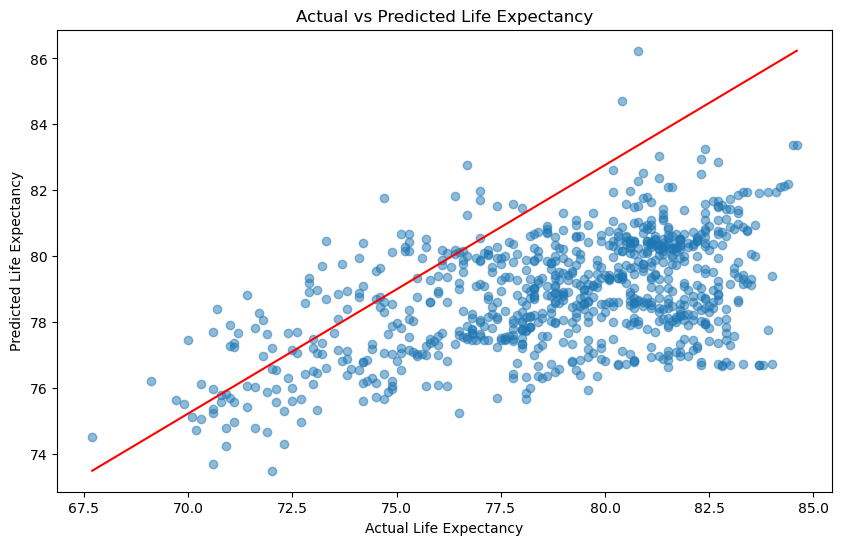

In [16]:
# Ensure no infinite values are present
X = np.nan_to_num(X, nan=np.nanmean(X), posinf=np.nanmax(X), neginf=np.nanmin(X))

# Add a constant to the predictors for statsmodels
X_sm = sm.add_constant(X)

# Initialize and fit the model using statsmodels for detailed statistics
model_sm = sm.OLS(y, X_sm).fit()
print(model_sm.summary())

# Check for multicollinearity using Variance Inflation Factor (VIF)
vif_data = pd.DataFrame()
vif_data["feature"] = ['constant'] + list(df_merged.columns[:-1])
vif_data["VIF"] = [variance_inflation_factor(X_sm, i) for i in range(X_sm.shape[1])]
print(vif_data)

# Predicting life expectancy using the fitted model
y_pred = model_sm.predict(X_sm)

# Plotting actual vs. predicted life expectancy
plt.figure(figsize=(10, 6))
plt.scatter(y, y_pred, alpha=0.5)
plt.plot([min(y), max(y)], [min(y_pred), max(y_pred)], color='red')  # Line of perfect prediction
plt.xlabel('Actual Life Expectancy')
plt.ylabel('Predicted Life Expectancy')
plt.title('Actual vs Predicted Life Expectancy')
plt.show()

The pairing graph between actual and predicted life expectancy displays a positive correlation, yet it reveals considerable variance in the model's predictive accuracy. The concentration of data points around the line of perfect prediction, depicted in red, indicates a general alignment of predicted values with actual life expectancy, particularly within the median range of the data. However, the spread of points above and below this line suggests deviations from perfect prediction, with the model's performance appearing less accurate at the extremities of life expectancy values. This is likely due to the large number of predictors and correlated datapoints from each country. We would now like to employ train test split to have a measurement for how well our model predict unseen data.

The OLS regression details accompanying the graph, showed an R-squared value of 0.265, meaning that approximately 26.5% of the variance in life expectancy is explained by the model, which aligns with the spread observed in the scatter plot. The graph also shows some potential outliers, particularly at the lower end of actual life expectancy, where predictions are less congruent with observed values. These outliers could significantly influence the regression model's coefficients and overall fit, potentially skewing the results.

The extent of dispersion from the line of perfect prediction indicates that while the model captures some of the trends in life expectancy, over 70% of the variability is unaccounted for by the model's predictors. This underscores the need for a more nuanced model or the inclusion of additional relevant variables to enhance predictive accuracy and better understand the factors influencing life expectancy.

Now, we will employa  train test split to have a measurement for how well our model can predict unseen data:

r2_score: 0.204875121769595
MSE: 7.755260930856818


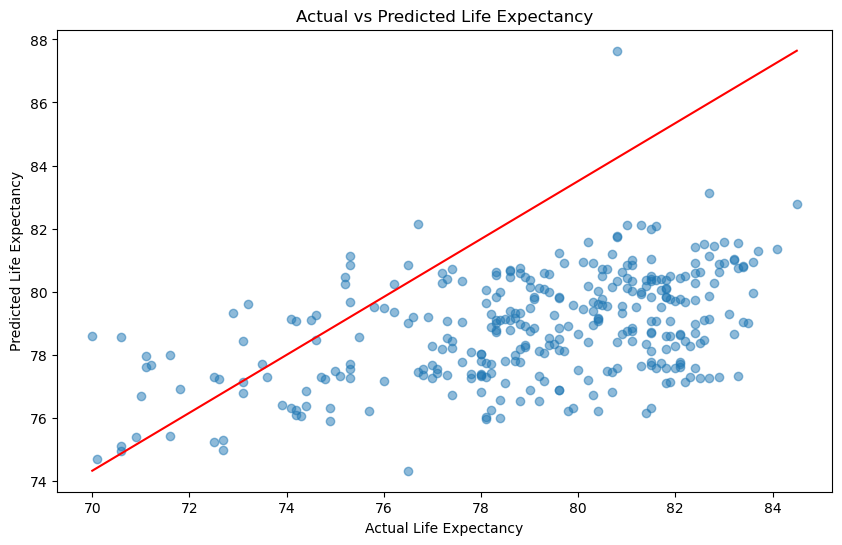

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)

lr = LinearRegression().fit(X_train, y_train)
y_pred = lr.predict(X_test)
print("r2_score:", r2_score(y_test, y_pred))
print("MSE:", mean_squared_error(y_test, y_pred))

# Plotting actual vs. predicted life expectancy
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_pred), max(y_pred)], color='red')  # Line of perfect prediction
plt.xlabel('Actual Life Expectancy')
plt.ylabel('Predicted Life Expectancy')
plt.title('Actual vs Predicted Life Expectancy')
plt.show()

As expected, the prediction is no longer perfect, though an R^2 score of 0.2048 is representative of a mediocre fit. This is likely due to the fact that we are consistently underpredicting the life expectancy. Note that in this example, we only use a singular predictor.  

As a fix, we will be incusive of more predictors and interaction terms in our model using polynomial regression, then prune the predictors using LASSO:

r2_score: 0.731136735377283
MSE: 2.622361378644941


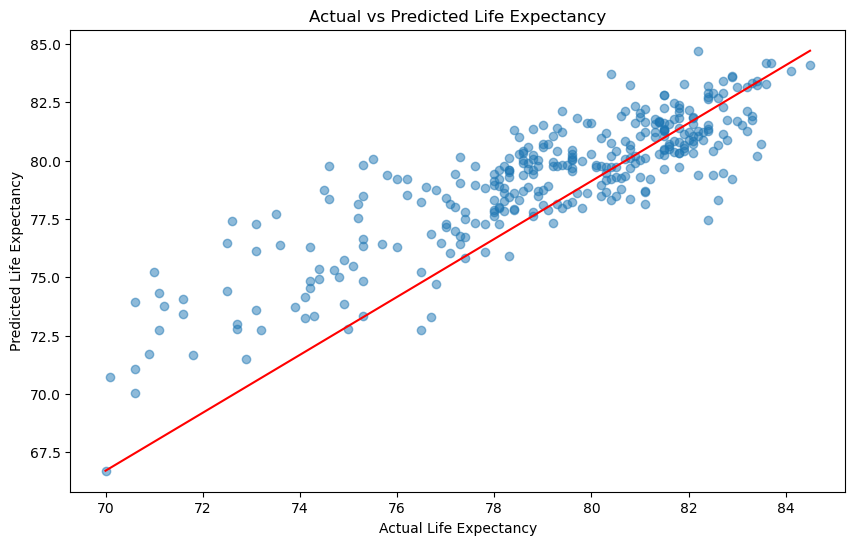

In [18]:
# Generate polynomial features
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

# Initialize and fit the model
lr_poly = LinearRegression().fit(X_train_poly, y_train)
X_test_poly_pred = lr_poly.predict(X_test_poly)
print("r2_score:", r2_score(y_test, X_test_poly_pred))
print("MSE:", mean_squared_error(y_test, X_test_poly_pred))

# Plotting actual vs. predicted life expectancy
plt.figure(figsize=(10, 6))
plt.scatter(y_test, X_test_poly_pred, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(X_test_poly_pred), max(X_test_poly_pred)], color='red')  # Line of perfect prediction
plt.xlabel('Actual Life Expectancy')
plt.ylabel('Predicted Life Expectancy')
plt.title('Actual vs Predicted Life Expectancy')
plt.show()

The inclusion of additional predictors has notably enhanced our model's predictive power, albeit at the cost of making it more complex and challenging to interpret due to the increased number of variables at play. To address this, we are implementing LASSO regression to isolate the most salient predictors to make our results interpretable.

Our existing models, encompassing linear, multiple, and polynomial regressions, are at risk of overfitting, which could limit their applicability to new datasets. To mitigate this, we have applied regularization techniques, such as LASSO, which penalize model complexity and encourage simplicity. This not only helps in preventing overfitting but may also improve the model's generalizability.

Furthermore, considering that government healthcare expenditure might be interlinked with other forms of spending, such as education, or with broader economic measures like GDP, our models are potentially vulnerable to multicollinearity. LASSO assists in this context by performing feature selection, effectively reducing some coefficients to zero. This enables us to discern which variables, among different types of government outlays, most effectively predict healthcare outcomes. Such insights are incredibly valuable, as they could reveal whether there are diminishing returns to healthcare investments or if some forms of expenditure are more effective than others in enhancing life expectancy at birth:

Alpha: 0.0010434478991718688
r2_score: 0.22049420017311394
MSE: 7.602920044745467


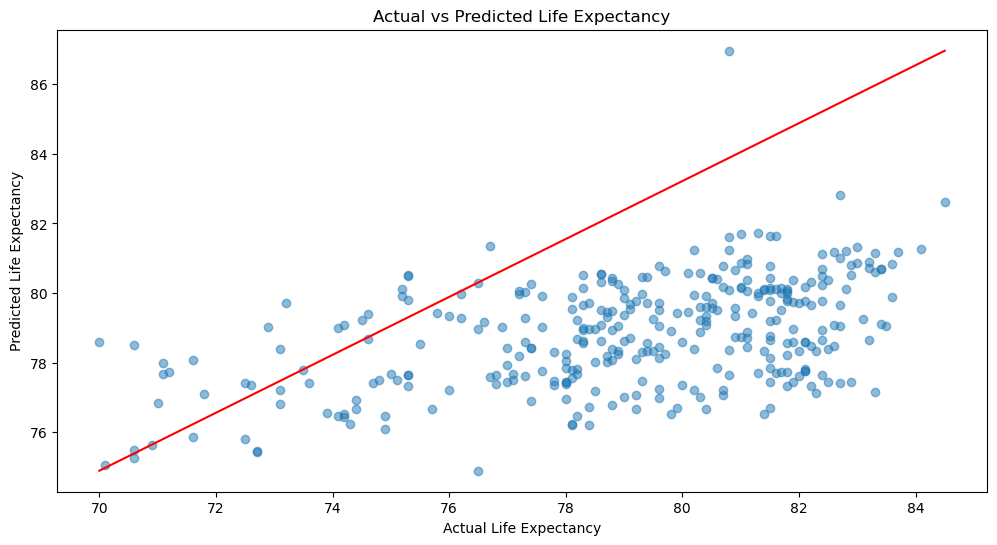

In [19]:
# Create pipelines for LASSO
lasso = LassoCV(cv=10, random_state=0, max_iter=100000)

# Fit models
lasso.fit(X_train, y_train)

# Print results
print("Alpha:", lasso.alpha_)

# Predictions
y_pred_lasso = lasso.predict(X_test)
print("r2_score:", r2_score(y_test, y_pred_lasso))
print("MSE:", mean_squared_error(y_test, y_pred_lasso))

# Plotting
plt.figure(figsize=(12, 6))
plt.scatter(y_test, y_pred_lasso, alpha=0.5, label='LASSO Predictions')
plt.plot([y_test.min(), y_test.max()], [y_pred_lasso.min(), y_pred_lasso.max()], color='red', label='Perfect Prediction')
plt.xlabel('Actual Life Expectancy')
plt.ylabel('Predicted Life Expectancy')
plt.title('Actual vs Predicted Life Expectancy')
plt.show()

In [20]:
for coef, predictor in sorted(zip(lasso.coef_.flatten(), list(df_merged.columns))):
    print("\t{:<20}{:.8f}".format(predictor, coef))


	expitem3            -77.62457759
	expitem1            0.00000000
	expitem11           -0.00000000
	expitem7            0.00000000
	expitem9            -0.00000000
	expitem4            9.58978063
	expitem6            20.34049345
	expitem10           24.57236976
	expitem5            29.11091478
	expitem8            33.39448962
	expitem2            64.17039555


In the output from the LASSO regression, we see that about half of the coefficients have been shrunk towards zero, which is a characteristic effect of LASSO in promoting sparsity in the model. The coefficients that remain non-zero are considered by Lasso to be the most important predictors in the context of the model given the regularization constraint applied. From the list provided, the non-zero coefficients are as follows (note that these predicators are scaled by a factor billion, given that the changes in years would be very small, realistically):

- expitem3 (Wage Consumption): The coefficient is -77.62457759, which suggests that as this predictor increases by one unit, the response variable is expected to decrease by approximately 77.62 units, holding all other predictors constant. However, the large negative coefficient may indicate that this variable has a strong inverse relationship with the dependent variable, or it could be an outlier or an artifact of over-penalization.

- expitem4 (Pension Spending): This variable has a coefficient of 9.5898063, indicating a positive relationship with the response variable.

- expitem6 (Unemployment Benefit Spending): With a coefficient of 20.3409345, this predictor also shows a positive association, with an increase in one unit of this predictor expected to increase the response by approximately 20.34 units.

- expitem10 ("Other Primary" Spending): This variable has a coefficient of 24.57236976, suggesting it's a strong positive predictor in the model.

- expitem5 (Sickness & Disability Spending): The coefficient of 29.11091478 indicates a relatively large positive effect on the response variable.

- expitem8 (Subsidy Spending): With a coefficient of 33.39448962, this variable is also positively associated with the response variable and is one of the stronger predictors in the model.

- expitem2 (Health Spending): This has the largest positive coefficient at 64.17039555, suggesting that it has the strongest positive association with the response variable among all predictors included in the model.

Note again that we are not very confident about the validity of this result as we are treating each country-year observation as independent from each other even though there should be a lot of correlation between them. We would like to explore methods to decrease the multicollinearity in our dataset next.

**Random Forest & Feature Importance**

We next would like to explore if using a Random Forest would give us new or different insights about which expenditure items are the most important. First we would need to tune our RF across hyperparameters to find the best split. Then by using RF's 'feature_importances_' attribute, we can sort the expenditure items by importance to uncover the top ones.

In [24]:
rf2 = GridSearchCV(estimator=RandomForestRegressor(random_state=109),
                  param_grid={'min_samples_split': [2,5,10,20,30],
                              'max_features': [2,5,8]},
                  cv=5)
rf2.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=109),
             param_grid={'max_features': [2, 5, 8],
                         'min_samples_split': [2, 5, 10, 20, 30]})

In [25]:
rf2.best_params_

{'max_features': 8, 'min_samples_split': 2}

In [26]:
rf_tuned = RandomForestRegressor(max_features=rf2.best_params_['max_features'],
                                 min_samples_split=rf2.best_params_['min_samples_split'],
                                 random_state=109).fit(X_train, y_train)
rf_tuned.fit(X_train, y_train)
random_forest_train_score = rf_tuned.score(X_train, y_train)
random_forest_test_score = rf_tuned.score(X_test, y_test)

In [27]:
# print results summary
print(random_forest_train_score, random_forest_test_score)

0.9773731704368487 0.811229200446559


Test score indicates that this is a generally okay fit to the data.

Text(0.5, 1.0, 'Relative Variable Importance')

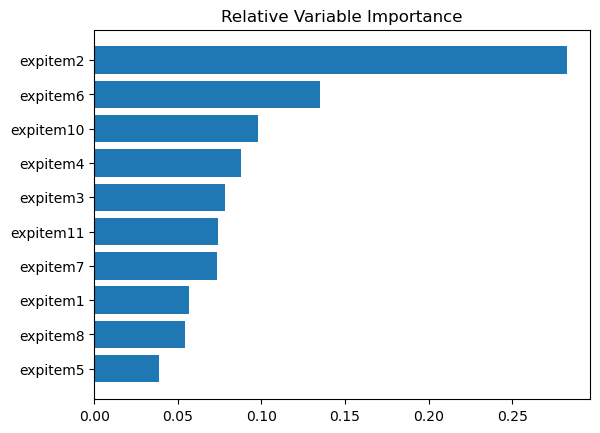

In [33]:
num_features = 10 
importances = rf_tuned.feature_importances_
order = np.argsort(importances)[-num_features:]
plt.barh(range(num_features), importances[order], tick_label=df_merged.columns[order]);
plt.title(f"Relative Variable Importance")

We see that similar to LASSO, Health expenditures (expitem2) remains the most important predictor. However, the runner up are now Unemployment benefit expenditures (expitem6), Other expenditures (expitem10), and Pension expenditures (expitem4). This does make sense as unemployed and the elderly are among the most vulnerable groups in a country. By spending money on programs that benefit them, we can most efficiently reduce illness and death in the population, prolonging the average life expectancy

**Conclusion and Takeaways**

In conclusion, the core methodologies that we chose to implore when exploring the relaitonship between life expectancy at birth and government expenditures included linear regression, mean squared error (MSE) calculation, R-squared value computation, Lasso and Ridge regression, and polynomial feature engineering, among others. These techniques were integral to understanding and quantifying the impact of health expenditures on life expectancy across various countries.

Linear regression models were created for different countries, including the USA, South Korea, Denmark, and Great Britain. Each model focused on the relationship between healthcare spending ('expitem2') and life expectancy ('Life_exp'). We then fits these models and visualizes the results, plotting the actual data against the fitted regression lines. This approach provides a clear visual representation of the relationship between the variables. For each country, we calculated the mean squared error (MSE) and R-squared value of the regression models. The MSE measures the average squared difference between the observed actual outcomes and the outcomes predicted by the model, giving an indication of the prediction accuracy, where a lower MSE signified a model that closely predicts actual life expectancy. the R-squared value, on the other hand, represents the proportion of the variance in life expectancy that is predictable from the health expenditures. A higher R-squared value indicates a model that effectively captures the variability in life expectancy. Additionally, the use of LassoCV and RidgeCV reflected our effort to refine the models by penalizing the complexity of the model, thus preventing overfitting and enhancing the generalizability of our findings. Polynomial features were used in an attempt to capture more complex, non-linear relationships between health expenditures and life expectancy. From these techniques, we were only able to come to limited conlusions about the relationship between life expectancy and government expenditures:

- Country-Specific Impact of Health Expenditures: The separate linear regression models for each country (USA, South Korea, Denmark, Great Britain) imply that health expenditures have a variable impact on life expectancy across different national contexts. The fact that different models were needed for each country suggests that the relationship between health spending and life expectancy is not uniform across the board but is influenced by country-specific factors. This is expected given that its more likely to see relationships within a nation that across all nations, which have uncountable factors that effect their expenditures.

- Model Accuracy and Predictive Power: When looking at MSE's for specific countries in the dataset, we observed low MSEs relative the range of life expectancy at birth, would suggested that the models are more accurately predicting life expectancy based on health expenditures in that particular country. The R-squared values, indicating the proportion of variance in life expectancy explained by health expenditures, offered insights into the predictive power of these expenditures, which also differed highly by country.

- Complexity of Relationships: The use of polynomial features and advanced regression techniques (LassoCV, RidgeCV) suggests that the relationship between health expenditures and life expectancy is complex and potentially non-linear, which is also expected. This complexity might arise from the interplay of health expenditures with other socio-economic and health-related variables, which vary from one country to another, similarly to what we observed on a small level for our simple linear model.

- Effectiveness of Health Spending: If the models for certain countries show both low MSE and high R-squared values, it could be concluded that health spending in those countries is an effective predictor of life expectancy. This would imply that increases in health expenditures in these countries are likely to be associated with proportional increases in life expectancy. We state this with caution as we acknowledge that truncating the years from 1995-2021 and thus number of observations to about 26 per country made our models extremly prone to overfitting.

- Differences in Health Outcomes Across Countries: The varying strengths of the models for different countries likely highlight disparities in health outcomes and the effectiveness of health spending. Developed countries with well-established healthcare systems might show a stronger correlation between health expenditures and life expectancy compared to developing countries.

- Overfitting Concerns: The use of LassoCV and RidgeCV models indicates an awareness of potential overfitting and a deliberate effort to create models that are generalizable and not just tailored to the sample data. This approach enhances the reliability of the conclusions drawn about the relationship between health expenditures and life expectancy.

In summary, the statistical analyses likely reveal that health expenditures have a significant but varied impact on life expectancy across different countries. The effectiveness of health spending in predicting life expectancy appears to be influenced by a country's unique socio-economic and healthcare context, with more developed countries possibly showing a stronger correlation. The analysis also underscores the complexity and multifaceted nature of the relationship between health spending and life expectancy.

**Bonus Secction: Post Double Selection Lasso (Belloni, A., Chernozhukov, V., and Hansen, C. (2014))**

In [21]:
no_exp2 = np.delete(X_train, 1, 1)
l = list(df_merged.columns)
l.remove('expitem2')

In [22]:
lasso1 = LassoCV(cv=10, random_state=0, max_iter=10000)
lasso1.fit(no_exp2, y_train)
for coef, predictor in zip(lasso1.coef_.flatten(), l):
    print("\t{:<20}{:.8f}".format(predictor, coef))

	expitem1            -0.00000000
	expitem10           0.00000000
	expitem11           64.42435302
	expitem3            -75.04537554
	expitem4            10.82799110
	expitem5            28.71669468
	expitem6            25.79088032
	expitem7            0.00000000
	expitem8            44.30467690
	expitem9            0.00000000


In [23]:
lasso2 = LassoCV(cv=10, random_state=0, max_iter=10000)
lasso2.fit(no_exp2, X_train[:, 1])
for coef, predictor in zip(lasso2.coef_.flatten(), l):
    print("\t{:<20}{:.8f}".format(predictor, coef))

	expitem1            -0.42129099
	expitem10           0.14766535
	expitem11           -0.00000000
	expitem3            0.12213851
	expitem4            0.06071630
	expitem5            0.03983746
	expitem6            0.28855368
	expitem7            0.14395688
	expitem8            0.52787044
	expitem9            0.43033518
